## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2024                               # What year to start the run on? (default: 2024)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/minimal_menace')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/minimal_menace.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-03-15 12:26:23.875058


{1: 24.0,
 5: 25.1,
 10: 25.8,
 20: 26.8,
 30: 27.8,
 40: 29.3,
 50: 31.1,
 60: 33.0,
 70: 35.1,
 80: 37.3,
 90: 40.9,
 95: 43.7,
 99: 49.8}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-03-15 12:27:41.902659


{1: 8.0,
 5: 8.2,
 10: 8.4,
 20: 8.6,
 30: 8.8,
 40: 8.9,
 50: 9.1,
 60: 9.2,
 70: 9.4,
 80: 9.6,
 90: 9.9,
 95: 10.1,
 99: 10.5}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-03-15 12:30:55.271687


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=4.04, lognorm_sd=3.21, norm_mean=1.15, norm_sd=0.7) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)},
 'robotics': {'pro

In [6]:
def wildeford_max_gdp_frac():
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.8:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.015, 0.8, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)

    frac = ~gdp_frac * ~percent_spent_on_compute * ~percent_spent_on_largest_model
    frac = 1 / (4*K) if frac < (1 / (4*K)) else frac
    gpd_frac = 1 / (4*K) if gdp_frac < (1 / (4*K)) else gdp_frac
    return {'total_frac': gdp_frac, 'compute_frac': frac}


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.lognorm(18, 19.5),  # https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'], # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 8.5, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

#### Total % of GDP spent on entire project

In [7]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 46064.22it/s]


{1: 0.00071,
 5: 0.00106,
 10: 0.00133,
 20: 0.00175,
 30: 0.00217,
 40: 0.00258,
 50: 0.00315,
 60: 0.00386,
 70: 0.00501,
 80: 0.0079,
 90: 0.01174,
 95: 0.01476,
 99: 0.02022}

In [8]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.071%',
 5: '0.106%',
 10: '0.133%',
 20: '0.175%',
 30: '0.217%',
 40: '0.258%',
 50: '0.315%',
 60: '0.386%',
 70: '0.501%',
 80: '0.79%',
 90: '1.174%',
 95: '1.476%',
 99: '2.022%'}

In [9]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '17.9 billion',
 5: '26.6 billion',
 10: '33.4 billion',
 20: '43.9 billion',
 30: '54.4 billion',
 40: '64.9 billion',
 50: '79.0 billion',
 60: '97.1 billion',
 70: '125.7 billion',
 80: '198.7 billion',
 90: '294.0 billion',
 95: '371.4 billion',
 99: '508.8 billion'}

#### Total GDP spent on compute for largest model

In [10]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 883755.58it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.00025,
 60: 0.00036,
 70: 0.00055,
 80: 0.00089,
 90: 0.00167,
 95: 0.00279,
 99: 0.00715}

In [11]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.025%',
 5: '0.025%',
 10: '0.025%',
 20: '0.025%',
 30: '0.025%',
 40: '0.025%',
 50: '0.025%',
 60: '0.036%',
 70: '0.055%',
 80: '0.089%',
 90: '0.167%',
 95: '0.279%',
 99: '0.715%'}

In [12]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6.2 billion',
 5: '6.2 billion',
 10: '6.3 billion',
 20: '6.3 billion',
 30: '6.3 billion',
 40: '6.3 billion',
 50: '6.3 billion',
 60: '8.9 billion',
 70: '13.7 billion',
 80: '22.3 billion',
 90: '41.9 billion',
 95: '69.9 billion',
 99: '179.6 billion'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 29.1 log FLOP (~125.9 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5.0 quintillion) per 2023$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~868.6 sextillion) per 2023$USD.
We are initially willing to pay 8.6 log 2023$USD (~381.4 million). This doubles every 1.1 year to a max of 0.035785% of GDP (initially ~9.1 billion 2023$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2024 - 27.3 max log FLOP available - TAI takes 29.1 log FLOP - log 2023$USD 10.4 to buy TAI vs. willingness to pay log $ 8.6 - 18.7 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
Year: 2025 - 27.7 max log FLOP available - TAI takes 29.0 log FLOP - log 2023$USD 10.2 to buy TAI vs. willingness to pay log $ 8.8 - 18.8 log FLOP per $ (Total FLOP 27.7 vs. Effective 2023-logFLOP: 27.7)
Year: 2026 - 28.0 max log FLOP available - TA

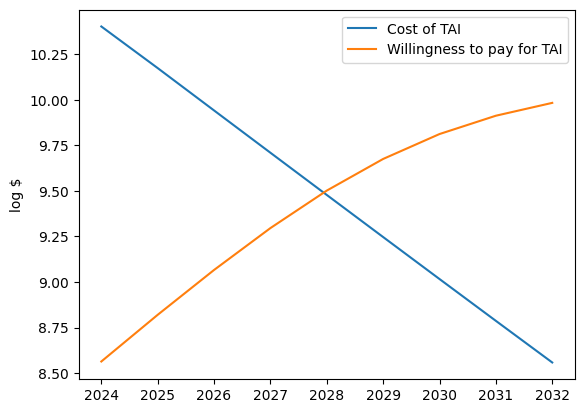

-
-
## SAMPLE RUN 2 ##
It takes 31.1 log FLOP (~12.6 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~15.8 quintillion) per 2023$USD. Every 2.1 years they get 2x cheaper, to a maximum of 26.9 log FLOP (~726.3 septillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~2.1 billion). This doubles every 1.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2024 - 28.4 max log FLOP available - TAI takes 31.1 log FLOP - log 2023$USD 11.9 to buy TAI vs. willingness to pay log $ 9.2 - 19.2 log FLOP per $ (Total FLOP 28.4 vs. Effective 2023-logFLOP: 28.4)
Year: 2025 - 28.7 max log FLOP available - TAI takes 31.0 log FLOP - log 2023$USD 11.6 to buy TAI vs. willingness to pay log $ 9.3 - 19.3 log FLOP per $ (Total FLOP 28.7 vs. Effective 2023-logFLOP: 28.8)
Year: 2026 - 29.0 max log FLOP available - TAI tak

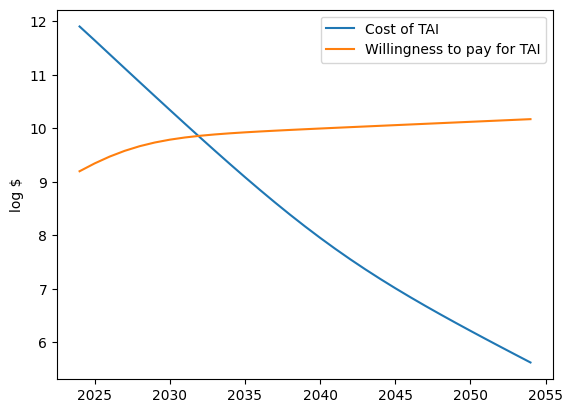

-
-
## SAMPLE RUN 3 ##
It takes 34.5 log FLOP (~31.6 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~6.7 quintillion) per 2023$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~200.1 sextillion) per 2023$USD.
We are initially willing to pay 8.4 log 2023$USD (~248.9 million). This doubles every 3.5 year to a max of 0.110132% of GDP (initially ~27.6 billion 2023$USD). GDP grows at a rate of 1.035x per year.
---
Year: 2024 - 27.2 max log FLOP available - TAI takes 34.5 log FLOP - log 2023$USD 15.7 to buy TAI vs. willingness to pay log $ 8.4 - 18.8 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.2)
Year: 2025 - 27.4 max log FLOP available - TAI takes 34.3 log FLOP - log 2023$USD 15.4 to buy TAI vs. willingness to pay log $ 8.5 - 18.9 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.6)
Year: 2026 - 27.6 max log FLOP available - TA

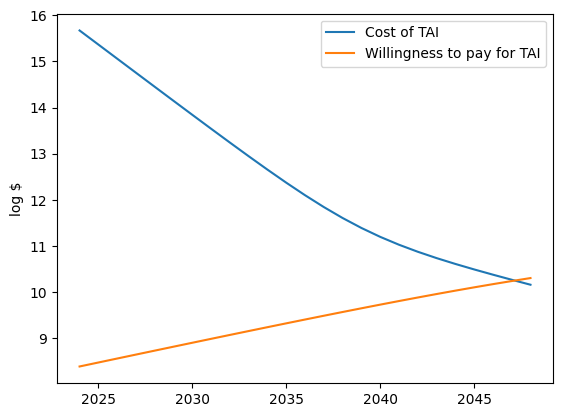

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.28it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 688.61it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2029',
 '10%: 2031',
 '15%: 2033',
 '20%: 2034',
 '25%: 2035',
 '35%: 2038',
 '50%: 2044',
 '60%: 2050',
 '75%: 2071',
 '80%: 2101',
 '90%: >2124',
 '95%: >2124']
(Mean: 2060)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 5 years from now',
 '10%: 7 years from now',
 '15%: 9 years from now',
 '20%: 10 years from now',
 '25%: 11 years from now',
 '35%: 14 years from now',
 '50%: 20 years from now',
 '60%: 26 years from now',
 '75%: 47 years from now',
 '80%: 77 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 36 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.3%
2024-2025: 0.5%
2026-2027: 1.2%
2028-2029: 4.2%
2030-2034: 16.6%
2035-2039: 16.8%
2040-2049: 21.1%
2050-2059: 10.8%
2060-2069: 3.9%
2070-2079: 3.2%
2080-2089: 1.7%
2090-2099: 0.7%

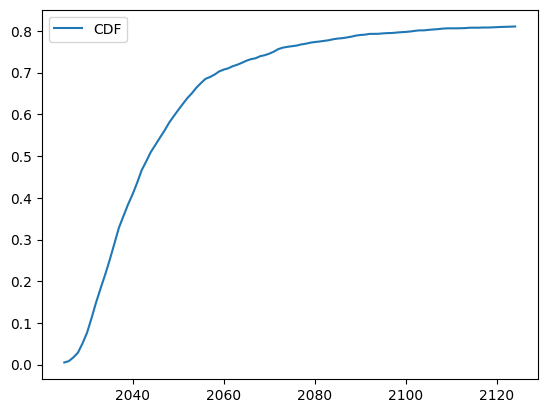

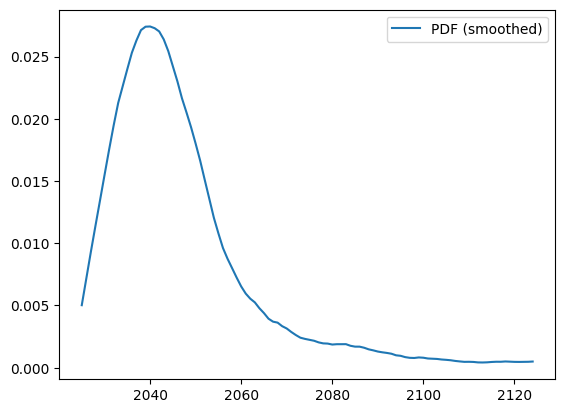

-
-
## TAI FLOP SIZE ##
{1: 24.0,
 5: 25.0,
 10: 25.8,
 20: 27.0,
 30: 27.9,
 40: 29.4,
 50: 31.1,
 60: 33.1,
 70: 35.1,
 80: 37.2,
 90: 40.7,
 95: 43.8,
 99: 49.3}
(Mean: 32.3)


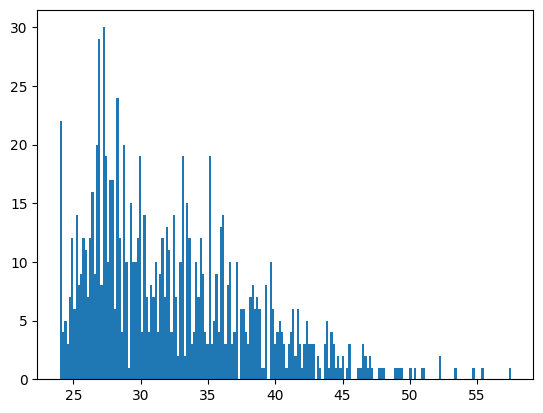

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 19.3,
 5: 15.1,
 10: 12.9,
 20: 10.1,
 30: 8.5,
 40: 7.5,
 50: 6.6,
 60: 5.9,
 70: 5.3,
 80: 4.5,
 90: 3.7,
 95: 2.9,
 99: 2.3}
(Mean: 7.6)


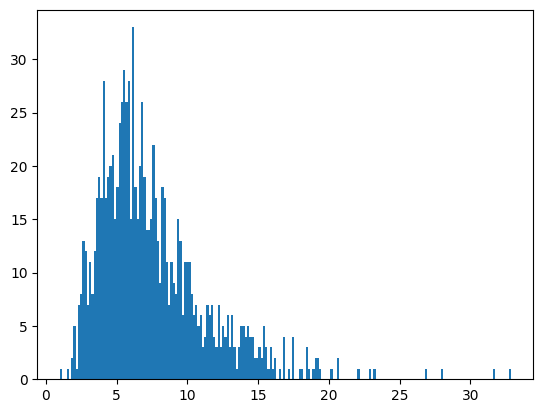

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR ##
{1: 17.6,
 5: 17.9,
 10: 18.1,
 20: 18.3,
 30: 18.5,
 40: 18.6,
 50: 18.7,
 60: 18.8,
 70: 19.0,
 80: 19.1,
 90: 19.4,
 95: 19.5,
 99: 19.8}
(Mean: 18.7)


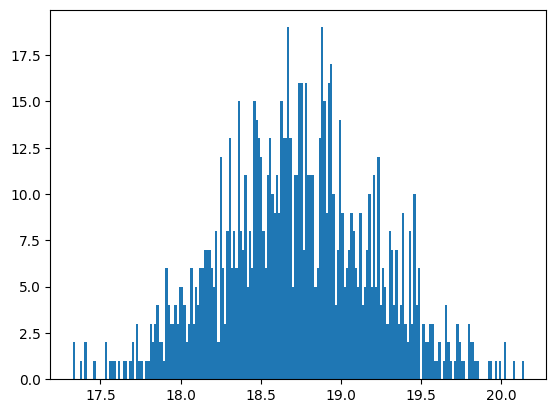

-
-
## FLOP HALVING RATE ##
{1: 3.2,
 5: 3.0,
 10: 2.9,
 20: 2.8,
 30: 2.7,
 40: 2.6,
 50: 2.5,
 60: 2.4,
 70: 2.3,
 80: 2.2,
 90: 2.1,
 95: 2.0,
 99: 1.8}
(Mean: 2.5)


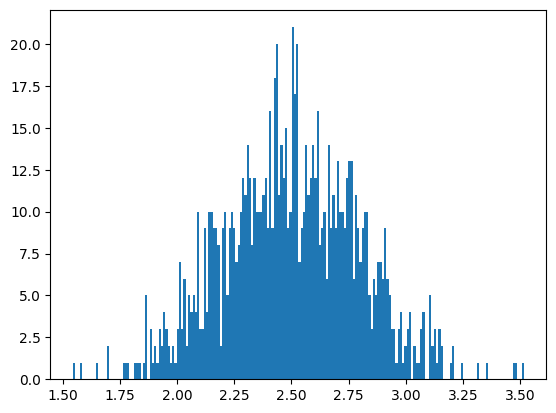

-
-
## MAX FLOP PER DOLLAR ##
{1: 19.9,
 5: 21.0,
 10: 21.5,
 20: 22.1,
 30: 22.6,
 40: 23.0,
 50: 23.5,
 60: 23.9,
 70: 24.3,
 80: 24.7,
 90: 25.4,
 95: 26.1,
 99: 27.3}
(Mean: 23.5)


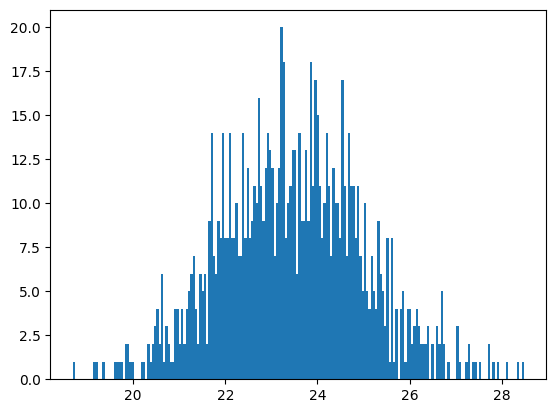

-
-
## INITIAL PAY ##
{1: 8.0,
 5: 8.3,
 10: 8.4,
 20: 8.6,
 30: 8.7,
 40: 8.9,
 50: 9.0,
 60: 9.2,
 70: 9.3,
 80: 9.6,
 90: 9.9,
 95: 10.1,
 99: 10.5}
(Mean: 9.1)


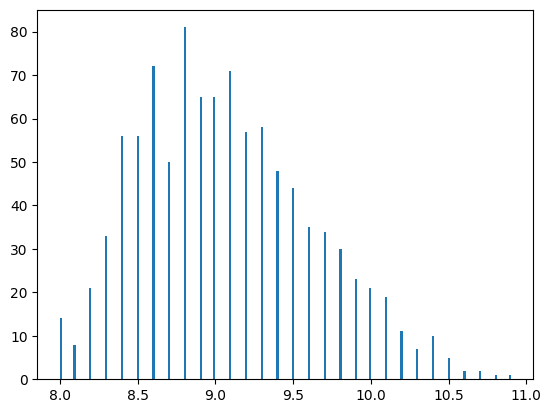

-
-
## INITIAL GDP ##
{1: 24804811324734.6,
 5: 24896162469184.84,
 10: 24937965745633.54,
 20: 24996371218967.66,
 30: 25044789856430.54,
 40: 25077607644299.56,
 50: 25113421404857.35,
 60: 25148149170253.28,
 70: 25185766237948.7,
 80: 25226130632142.35,
 90: 25282798950815.04,
 95: 25336381141499.24,
 99: 25415576857617.6}
(Mean: 25112933242064.7)


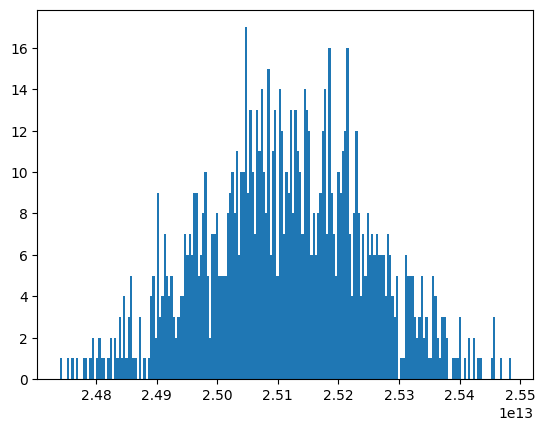

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}
(Mean: 1.0)


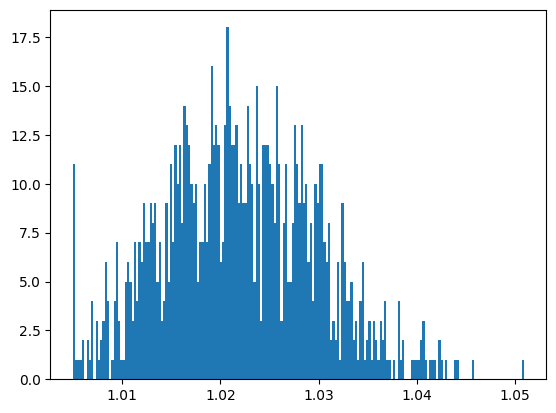

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.00026,
 60: 0.00037,
 70: 0.00056,
 80: 0.00086,
 90: 0.00149,
 95: 0.00234,
 99: 0.00571}
(Mean: 0.0)


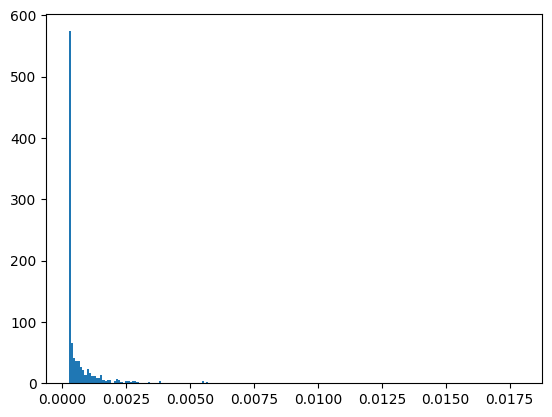

-
-
## SPEND DOUBLING TIME ##
{1: 13.5,
 5: 8.3,
 10: 6.6,
 20: 4.9,
 30: 4.1,
 40: 3.4,
 50: 3.0,
 60: 2.6,
 70: 2.2,
 80: 1.8,
 90: 1.3,
 95: 1.1,
 99: 0.9}
(Mean: 3.6)


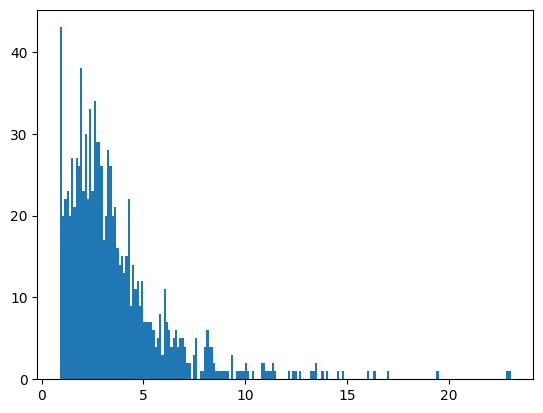

-
-
-
-
## GDP Over Time ##


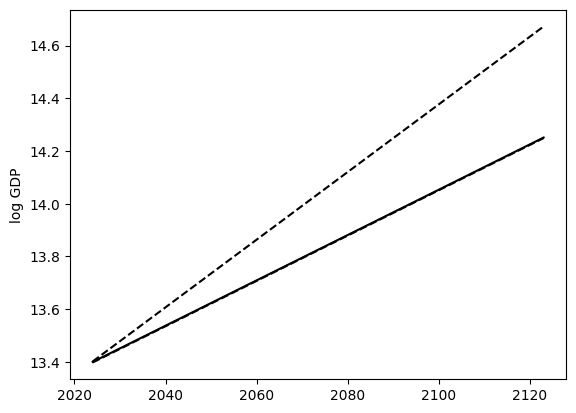

Year: 2024 - GDP log 2023$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2025 - GDP log 2023$USD 13.4 (~25.6 trillion) 80% CI 13.4 (~25.5 trillion) - 13.4 (~26.0 trillion)
Year: 2026 - GDP log 2023$USD 13.4 (~26.1 trillion) 80% CI 13.4 (~26.0 trillion) - 13.4 (~26.8 trillion)
Year: 2027 - GDP log 2023$USD 13.4 (~26.7 trillion) 80% CI 13.4 (~26.5 trillion) - 13.4 (~27.6 trillion)
Year: 2028 - GDP log 2023$USD 13.4 (~27.2 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~28.4 trillion)
Year: 2029 - GDP log 2023$USD 13.4 (~27.7 trillion) 80% CI 13.4 (~27.6 trillion) - 13.5 (~29.2 trillion)
Year: 2030 - GDP log 2023$USD 13.5 (~28.3 trillion) 80% CI 13.4 (~28.1 trillion) - 13.5 (~30.1 trillion)
Year: 2031 - GDP log 2023$USD 13.5 (~28.8 trillion) 80% CI 13.5 (~28.7 trillion) - 13.5 (~31.0 trillion)
Year: 2032 - GDP log 2023$USD 13.5 (~29.4 trillion) 80% CI 13.5 (~29.3 trillion) - 13.5 (~32.0 trillion)
Year: 2033 - GDP log 2023$USD 13.5 (~30.0 trillion) 80%

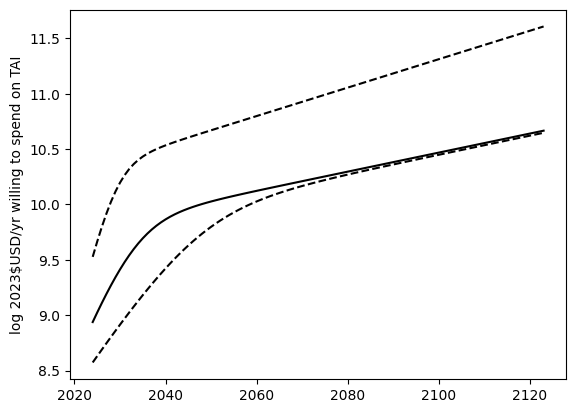

Year: 2024 - willingness log 2023$USD per year 8.9 (~867.2 million) 80% CI 8.6 (~374.3 million) - 9.5 (~3.4 billion)
Year: 2025 - willingness log 2023$USD per year 9.0 (~1.1 billion) 80% CI 8.6 (~427.8 million) - 9.7 (~4.6 billion)
Year: 2026 - willingness log 2023$USD per year 9.1 (~1.3 billion) 80% CI 8.7 (~488.6 million) - 9.8 (~6.3 billion)
Year: 2027 - willingness log 2023$USD per year 9.2 (~1.6 billion) 80% CI 8.7 (~557.4 million) - 9.9 (~8.2 billion)
Year: 2028 - willingness log 2023$USD per year 9.3 (~1.9 billion) 80% CI 8.8 (~635.2 million) - 10.0 (~10.5 billion)
Year: 2029 - willingness log 2023$USD per year 9.3 (~2.2 billion) 80% CI 8.9 (~722.9 million) - 10.1 (~13.1 billion)
Year: 2030 - willingness log 2023$USD per year 9.4 (~2.6 billion) 80% CI 8.9 (~821.7 million) - 10.2 (~15.7 billion)
Year: 2031 - willingness log 2023$USD per year 9.5 (~3.0 billion) 80% CI 9.0 (~932.4 million) - 10.3 (~18.4 billion)
Year: 2032 - willingness log 2023$USD per year 9.5 (~3.5 billion) 80% 

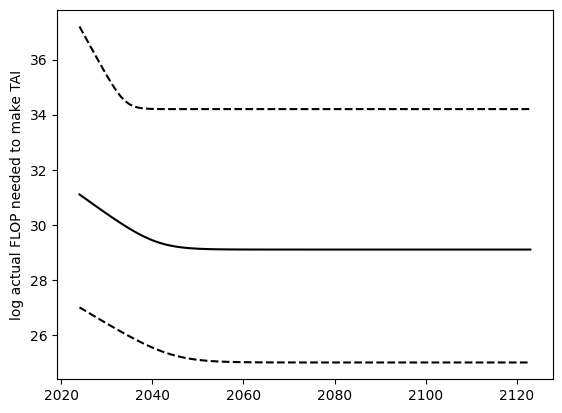

Year: 2024 - log FLOP needed for TAI 31.1 (~12.6 nonillion) 80% CI 27.0 (~1.0 octillion) - 37.2 (~15.8 thousand decillion)
Year: 2025 - log FLOP needed for TAI 31.0 (~9.7 nonillion) 80% CI 26.9 (~803.7 septillion) - 36.9 (~7.9 thousand decillion)
Year: 2026 - log FLOP needed for TAI 30.9 (~7.4 nonillion) 80% CI 26.8 (~640.0 septillion) - 36.6 (~4.0 thousand decillion)
Year: 2027 - log FLOP needed for TAI 30.7 (~5.6 nonillion) 80% CI 26.7 (~510.0 septillion) - 36.3 (~2.0 thousand decillion)
Year: 2028 - log FLOP needed for TAI 30.6 (~4.3 nonillion) 80% CI 26.6 (~406.9 septillion) - 36.0 (~1.0 thousand decillion)
Year: 2029 - log FLOP needed for TAI 30.5 (~3.3 nonillion) 80% CI 26.5 (~325.0 septillion) - 35.7 (~511.1 decillion)
Year: 2030 - log FLOP needed for TAI 30.4 (~2.5 nonillion) 80% CI 26.4 (~260.0 septillion) - 35.4 (~263.5 decillion)
Year: 2031 - log FLOP needed for TAI 30.3 (~1.9 nonillion) 80% CI 26.3 (~208.4 septillion) - 35.1 (~139.7 decillion)
Year: 2032 - log FLOP needed f

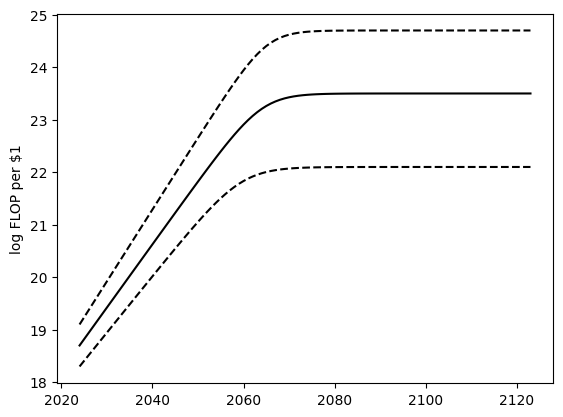

Year: 2024 - log FLOP per 2023$1USD 18.7 (~5.0 quintillion) 80% CI 18.3 (~2.0 quintillion) - 19.1 (~12.6 quintillion)
Year: 2025 - log FLOP per 2023$1USD 18.8 (~6.6 quintillion) 80% CI 18.4 (~2.6 quintillion) - 19.2 (~17.3 quintillion)
Year: 2026 - log FLOP per 2023$1USD 18.9 (~8.7 quintillion) 80% CI 18.5 (~3.3 quintillion) - 19.4 (~23.6 quintillion)
Year: 2027 - log FLOP per 2023$1USD 19.1 (~11.5 quintillion) 80% CI 18.6 (~4.2 quintillion) - 19.5 (~32.4 quintillion)
Year: 2028 - log FLOP per 2023$1USD 19.2 (~15.2 quintillion) 80% CI 18.7 (~5.4 quintillion) - 19.6 (~44.4 quintillion)
Year: 2029 - log FLOP per 2023$1USD 19.3 (~20.0 quintillion) 80% CI 18.8 (~6.9 quintillion) - 19.8 (~60.8 quintillion)
Year: 2030 - log FLOP per 2023$1USD 19.4 (~26.5 quintillion) 80% CI 18.9 (~8.8 quintillion) - 19.9 (~83.4 quintillion)
Year: 2031 - log FLOP per 2023$1USD 19.5 (~34.9 quintillion) 80% CI 19.1 (~11.3 quintillion) - 20.1 (~114.2 quintillion)
Year: 2032 - log FLOP per 2023$1USD 19.7 (~46.1 q

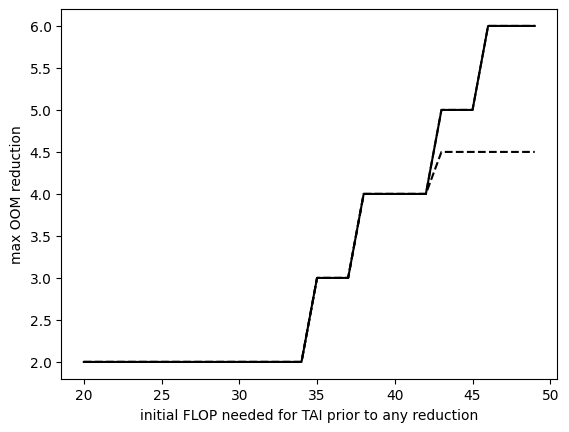

TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

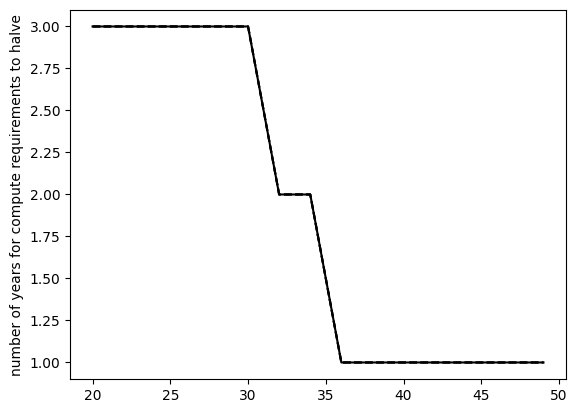

TAI log FLOP 20 -> algo doubling rate 3.0yrs (80% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (80% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (80% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (80% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (80% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (80% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (80% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (80% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (80% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (80% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (80% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (80% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (80% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (80% CI: 2.0 to 2.0)
TAI log FL

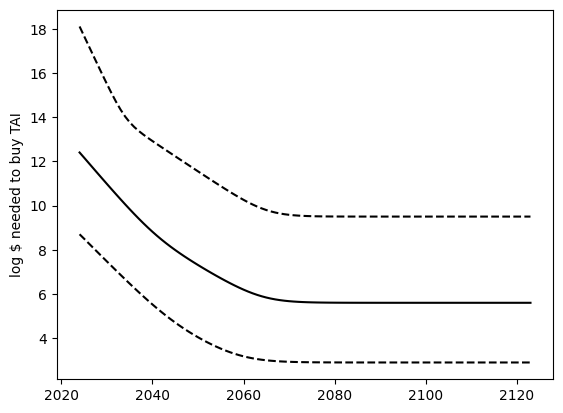

Year: 2024 - 12.4 log 2023$USD to buy TAI (~2.5 trillion) 80% CI 8.7 (~501.3 million) - 18.1 (~1.3 quintillion)
Year: 2025 - 12.2 log 2023$USD to buy TAI (~1.5 trillion) 80% CI 8.5 (~314.5 million) - 17.7 (~460.3 quadrillion)
Year: 2026 - 11.9 log 2023$USD to buy TAI (~843.1 billion) 80% CI 8.3 (~195.5 million) - 17.2 (~168.3 quadrillion)
Year: 2027 - 11.7 log 2023$USD to buy TAI (~486.9 billion) 80% CI 8.1 (~121.7 million) - 16.8 (~61.6 quadrillion)
Year: 2028 - 11.4 log 2023$USD to buy TAI (~281.6 billion) 80% CI 7.9 (~75.8 million) - 16.4 (~22.7 quadrillion)
Year: 2029 - 11.2 log 2023$USD to buy TAI (~163.3 billion) 80% CI 7.7 (~47.3 million) - 15.9 (~8.4 quadrillion)
Year: 2030 - 11.0 log 2023$USD to buy TAI (~94.9 billion) 80% CI 7.5 (~29.5 million) - 15.5 (~3.2 quadrillion)
Year: 2031 - 10.7 log 2023$USD to buy TAI (~55.4 billion) 80% CI 7.3 (~18.5 million) - 15.1 (~1.2 quadrillion)
Year: 2032 - 10.5 log 2023$USD to buy TAI (~32.5 billion) 80% CI 7.1 (~11.6 million) - 14.7 (~496.

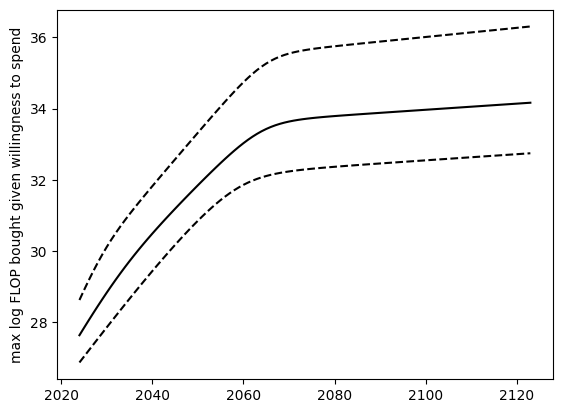

Year: 2024 - max log FLOP 27.6 (~4.3 octillion) 80% CI 26.9 (~746.6 septillion) - 28.6 (~42.3 octillion)
Year: 2025 - max log FLOP 27.8 (~7.0 octillion) 80% CI 27.0 (~1.1 octillion) - 28.9 (~80.0 octillion)
Year: 2026 - max log FLOP 28.1 (~11.2 octillion) 80% CI 27.2 (~1.6 octillion) - 29.2 (~148.0 octillion)
Year: 2027 - max log FLOP 28.3 (~17.9 octillion) 80% CI 27.4 (~2.3 octillion) - 29.4 (~267.1 octillion)
Year: 2028 - max log FLOP 28.5 (~28.2 octillion) 80% CI 27.5 (~3.4 octillion) - 29.7 (~468.4 octillion)
Year: 2029 - max log FLOP 28.6 (~44.2 octillion) 80% CI 27.7 (~5.0 octillion) - 29.9 (~796.4 octillion)
Year: 2030 - max log FLOP 28.8 (~68.5 octillion) 80% CI 27.9 (~7.2 octillion) - 30.1 (~1.3 nonillion)
Year: 2031 - max log FLOP 29.0 (~105.2 octillion) 80% CI 28.0 (~10.5 octillion) - 30.3 (~2.1 nonillion)
Year: 2032 - max log FLOP 29.2 (~159.8 octillion) 80% CI 28.2 (~15.3 octillion) - 30.5 (~3.3 nonillion)
Year: 2033 - max log FLOP 29.4 (~240.0 octillion) 80% CI 28.3 (~22.

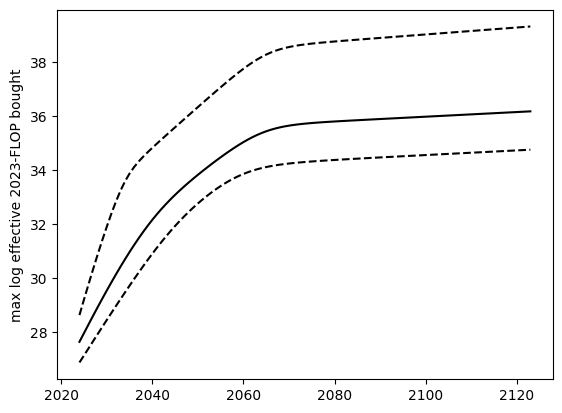

Year: 2024 - max log effective 2023-FLOP 27.6 (~4.3 octillion) 80% CI 26.9 (~746.6 septillion) - 28.6 (~42.3 octillion)
Year: 2025 - max log effective 2023-FLOP 28.0 (~9.1 octillion) 80% CI 27.1 (~1.4 octillion) - 29.2 (~159.7 octillion)
Year: 2026 - max log effective 2023-FLOP 28.3 (~19.2 octillion) 80% CI 27.4 (~2.5 octillion) - 29.8 (~589.6 octillion)
Year: 2027 - max log effective 2023-FLOP 28.6 (~40.1 octillion) 80% CI 27.7 (~4.6 octillion) - 30.3 (~2.1 nonillion)
Year: 2028 - max log effective 2023-FLOP 28.9 (~83.0 octillion) 80% CI 27.9 (~8.4 octillion) - 30.9 (~7.4 nonillion)
Year: 2029 - max log effective 2023-FLOP 29.2 (~169.9 octillion) 80% CI 28.2 (~15.3 octillion) - 31.4 (~24.7 nonillion)
Year: 2030 - max log effective 2023-FLOP 29.5 (~343.5 octillion) 80% CI 28.4 (~27.8 octillion) - 31.9 (~78.9 nonillion)
Year: 2031 - max log effective 2023-FLOP 29.8 (~685.0 octillion) 80% CI 28.7 (~50.4 octillion) - 32.4 (~238.1 nonillion)
Year: 2032 - max log effective 2023-FLOP 30.1 (~

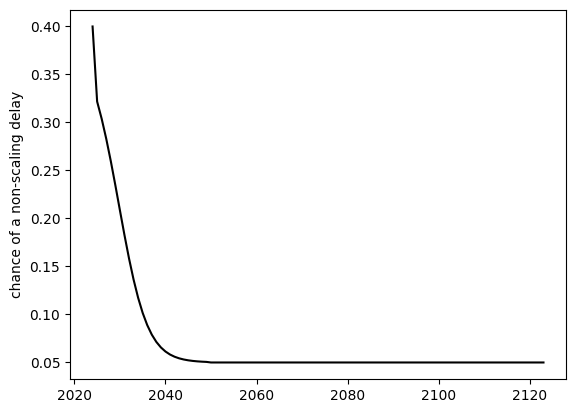

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2034

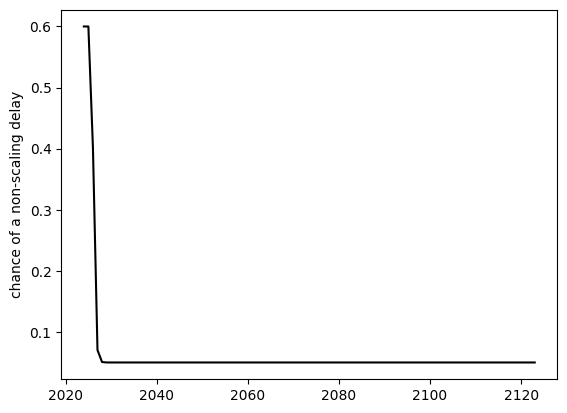

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chan

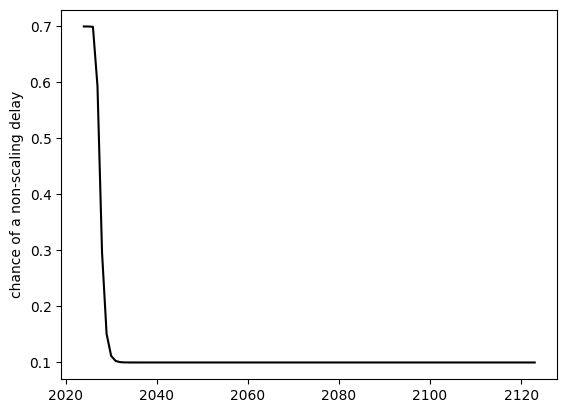

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2034

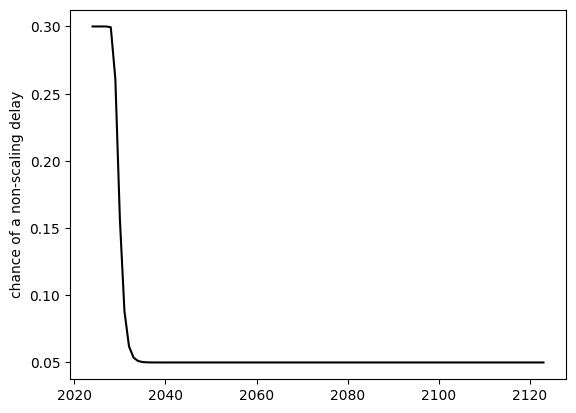

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - 

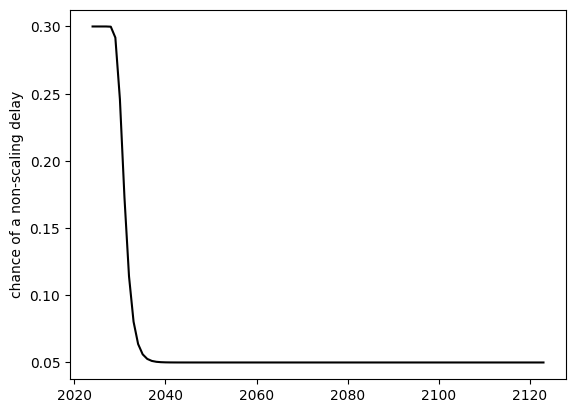

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2034 

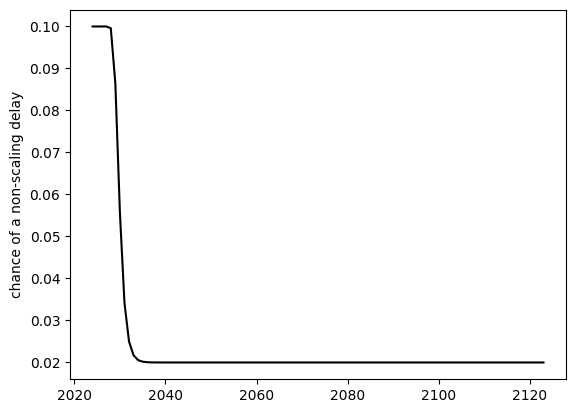

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 3%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 3%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2034 - ch

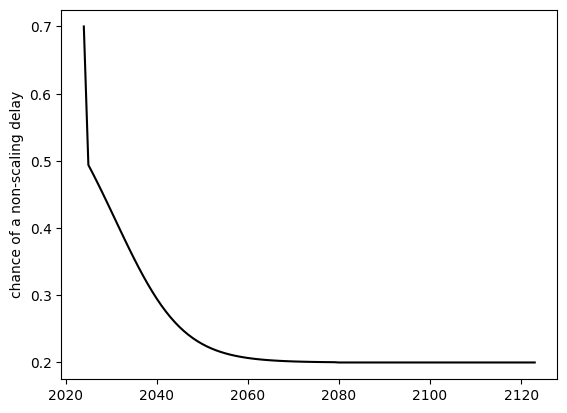

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 49%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 45%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 44%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 43%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 41%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 38%
Year: 2034

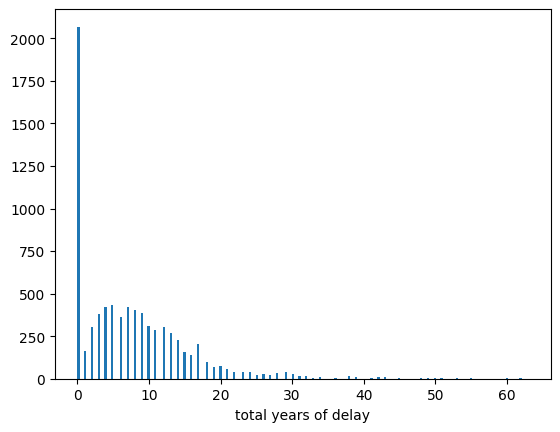

In [13]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 40.7 log FLOP (~50.1 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5.3 quintillion) per 2023$USD. Every 2.0 years they get 2x cheaper, to a maximum of 19.4 log FLOP (~25.4 quintillion) per 2023$USD.
We are initially willing to pay 9.6 log 2023$USD (~3.9 billion). This doubles every 2.6 year to a max of 0.588649% of GDP (initially ~148.3 billion 2023$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2024 - 28.2 max log FLOP available - TAI takes 40.7 log FLOP - log 2023$USD 22.1 to buy TAI vs. willingness to pay log $ 9.6 - 18.6 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.3)
Year: 2025 - 28.5 max log FLOP available - TAI takes 40.4 log FLOP - log 2023$USD 21.6 to buy TAI vs. willingness to pay log $ 9.7 - 18.8 log FLOP per $ (Total FLOP 28.5 vs. Effective 2023-logFLOP: 28.8)
Year: 2026 - 28.7 max log FLOP available

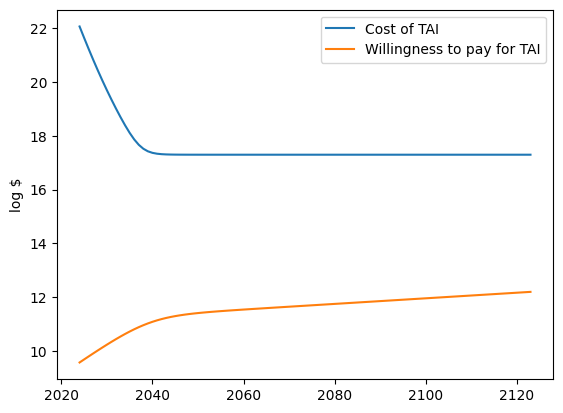

-
-
## SAMPLE RUN 5 ##
It takes 26.4 log FLOP (~251.2 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2023$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~7.5 septillion) per 2023$USD.
We are initially willing to pay 9.2 log 2023$USD (~1.5 billion). This doubles every 3.9 year to a max of 0.094492% of GDP (initially ~23.9 billion 2023$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2024 - 27.5 max log FLOP available - TAI takes 26.4 log FLOP - log 2023$USD 8.1 to buy TAI vs. willingness to pay log $ 9.1 - 18.3 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.5)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 10 years)
-- data p_nonscaling_iss

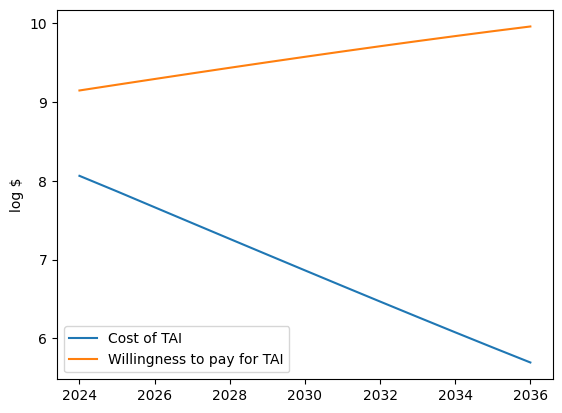

-
-
## SAMPLE RUN 6 ##
It takes 36.2 log FLOP (~1.6 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2023$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~87.8 sextillion) per 2023$USD.
We are initially willing to pay 9.7 log 2023$USD (~4.8 billion). This doubles every 1.3 year to a max of 0.532623% of GDP (initially ~133.4 billion 2023$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2024 - 28.1 max log FLOP available - TAI takes 36.2 log FLOP - log 2023$USD 17.7 to buy TAI vs. willingness to pay log $ 9.7 - 18.5 log FLOP per $ (Total FLOP 28.1 vs. Effective 2023-logFLOP: 28.1)
Year: 2025 - 28.5 max log FLOP available - TAI takes 35.9 log FLOP - log 2023$USD 17.3 to buy TAI vs. willingness to pay log $ 9.9 - 18.6 log FLOP per $ (Total FLOP 28.5 vs. Effective 2023-logFLOP: 28.8)
Year: 2026 - 28.8 max log FLOP availabl

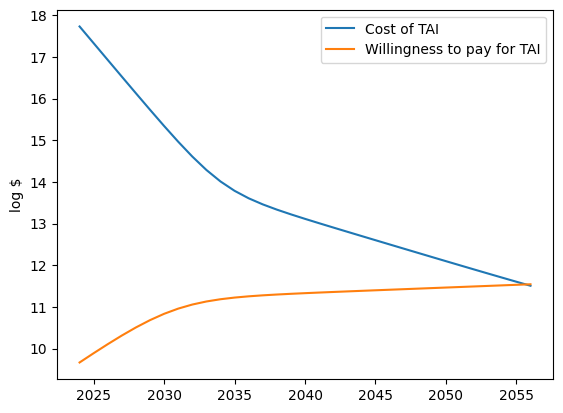

-
-
## SAMPLE RUN 7 ##
It takes 25.8 log FLOP (~63.1 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2023$USD. Every 2.9 years they get 2x cheaper, to a maximum of 27.4 log FLOP (~2.3 octillion) per 2023$USD.
We are initially willing to pay 8.9 log 2023$USD (~862.8 million). This doubles every 3.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2024 - 27.2 max log FLOP available - TAI takes 25.8 log FLOP - log 2023$USD 7.5 to buy TAI vs. willingness to pay log $ 8.9 - 18.3 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.2)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this d

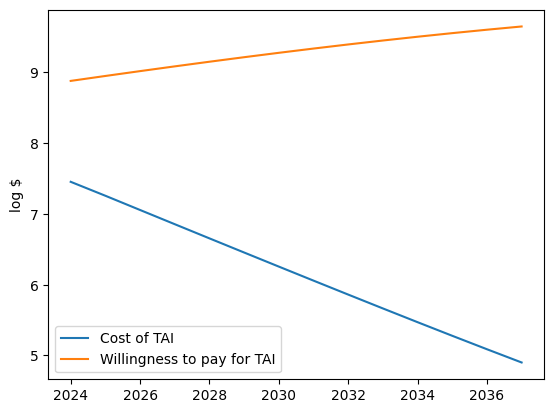

-
-
## SAMPLE RUN 8 ##
It takes 27.3 log FLOP (~2.0 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~9.0 quintillion) per 2023$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15.0 sextillion) per 2023$USD.
We are initially willing to pay 8.6 log 2023$USD (~374.4 million). This doubles every 6.3 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2024 - 27.5 max log FLOP available - TAI takes 27.3 log FLOP - log 2023$USD 8.3 to buy TAI vs. willingness to pay log $ 8.5 - 19.0 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.5)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- rob

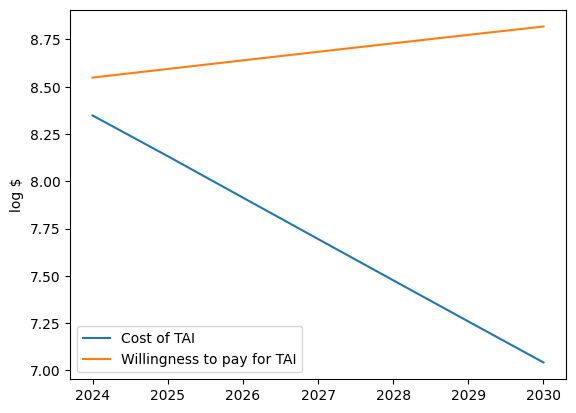

-
-
## SAMPLE RUN 9 ##
It takes 25.2 log FLOP (~15.8 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 17.8 log FLOP (~682.2 quadrillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~2.8 septillion) per 2023$USD.
We are initially willing to pay 9.7 log 2023$USD (~5.3 billion). This doubles every 2.2 year to a max of 0.04555% of GDP (initially ~11.4 billion 2023$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2024 - 27.4 max log FLOP available - TAI takes 25.2 log FLOP - log 2023$USD 7.4 to buy TAI vs. willingness to pay log $ 9.6 - 17.8 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 10 years (total delay 10 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-

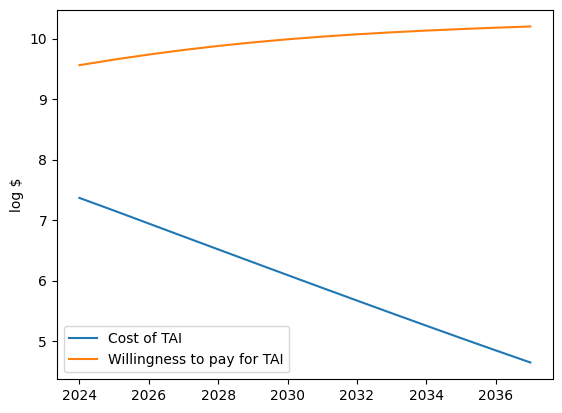

-
-
## SAMPLE RUN 10 ##
It takes 26.4 log FLOP (~251.2 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 17.7 log FLOP (~544.3 quadrillion) per 2023$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~18.1 sextillion) per 2023$USD.
We are initially willing to pay 8.5 log 2023$USD (~308.9 million). This doubles every 4.5 year to a max of 0.052837% of GDP (initially ~13.3 billion 2023$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2024 - 26.2 max log FLOP available - TAI takes 26.4 log FLOP - log 2023$USD 8.7 to buy TAI vs. willingness to pay log $ 8.5 - 17.7 log FLOP per $ (Total FLOP 26.2 vs. Effective 2023-logFLOP: 26.2)
Year: 2025 - 26.4 max log FLOP available - TAI takes 26.3 log FLOP - log 2023$USD 8.5 to buy TAI vs. willingness to pay log $ 8.5 - 17.8 log FLOP per $ (Total FLOP 26.4 vs. Effective 2023-logFLOP: 26.5)
-- algorithms p_nonscaling_issue p=0.3218 -> 

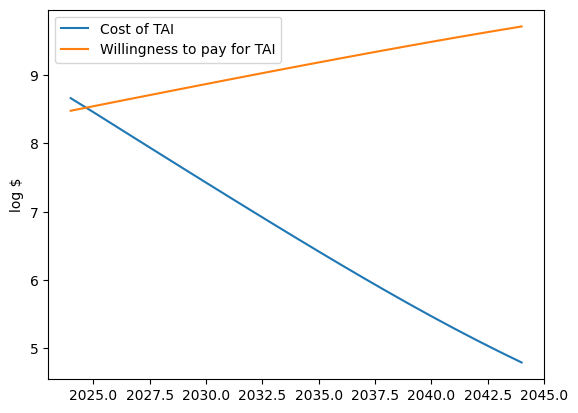

-
-
## SAMPLE RUN 11 ##
It takes 34.3 log FLOP (~20.0 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8.2 quintillion) per 2023$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~57.2 sextillion) per 2023$USD.
We are initially willing to pay 9.2 log 2023$USD (~1.5 billion). This doubles every 2.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2024 - 28.0 max log FLOP available - TAI takes 34.3 log FLOP - log 2023$USD 15.4 to buy TAI vs. willingness to pay log $ 9.1 - 18.9 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.0)
Year: 2025 - 28.2 max log FLOP available - TAI takes 34.1 log FLOP - log 2023$USD 15.1 to buy TAI vs. willingness to pay log $ 9.2 - 19.0 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.4)
Year: 2026 - 28.4 max log FLOP available - TAI takes

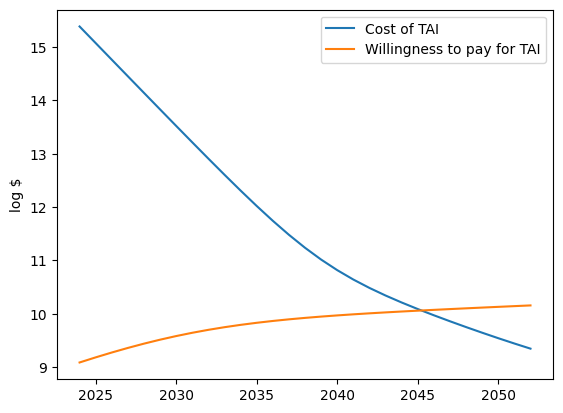

-
-
## SAMPLE RUN 12 ##
It takes 27.0 log FLOP (~1.0 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~14.6 quintillion) per 2023$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~4.8 septillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~1.9 billion). This doubles every 4.4 year to a max of 0.206481% of GDP (initially ~52.3 billion 2023$USD). GDP grows at a rate of 1.013x per year.
---
Year: 2024 - 28.4 max log FLOP available - TAI takes 27.0 log FLOP - log 2023$USD 7.8 to buy TAI vs. willingness to pay log $ 9.3 - 19.2 log FLOP per $ (Total FLOP 28.4 vs. Effective 2023-logFLOP: 28.4)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- 

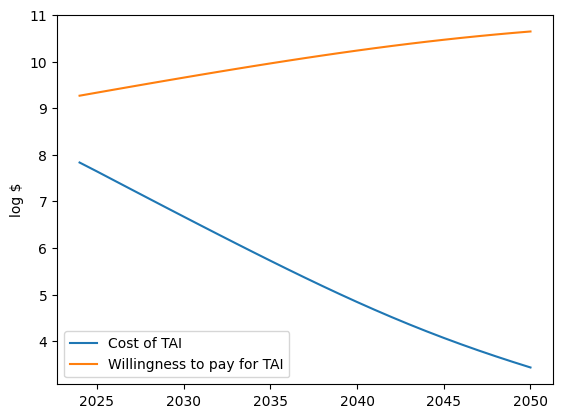

-
-
## SAMPLE RUN 13 ##
It takes 34.7 log FLOP (~50.1 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~3.7 quintillion) per 2023$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~162.2 sextillion) per 2023$USD.
We are initially willing to pay 9.5 log 2023$USD (~3.2 billion). This doubles every 3.1 year to a max of 0.026368% of GDP (initially ~6.6 billion 2023$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2024 - 27.9 max log FLOP available - TAI takes 34.7 log FLOP - log 2023$USD 16.1 to buy TAI vs. willingness to pay log $ 9.3 - 18.6 log FLOP per $ (Total FLOP 27.9 vs. Effective 2023-logFLOP: 27.9)
Year: 2025 - 28.1 max log FLOP available - TAI takes 34.5 log FLOP - log 2023$USD 15.8 to buy TAI vs. willingness to pay log $ 9.4 - 18.7 log FLOP per $ (Total FLOP 28.1 vs. Effective 2023-logFLOP: 28.3)
Year: 2026 - 28.3 max log FLOP available - TAI 

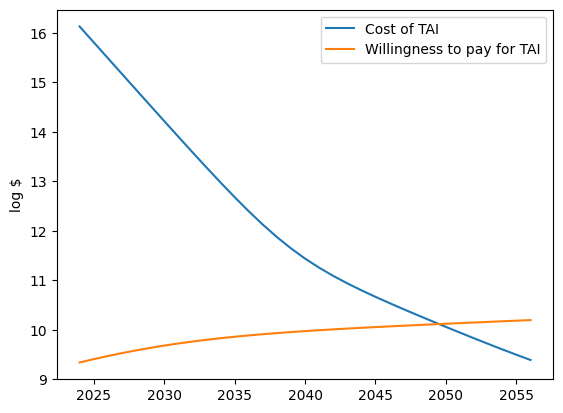

-
-
## SAMPLE RUN 14 ##
It takes 25.0 log FLOP (~10.0 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 17.9 log FLOP (~780.7 quadrillion) per 2023$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~822.6 sextillion) per 2023$USD.
We are initially willing to pay 8.9 log 2023$USD (~867.5 million). This doubles every 2.9 year to a max of 0.026138% of GDP (initially ~6.5 billion 2023$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2024 - 26.8 max log FLOP available - TAI takes 25.0 log FLOP - log 2023$USD 7.1 to buy TAI vs. willingness to pay log $ 8.9 - 17.9 log FLOP per $ (Total FLOP 26.8 vs. Effective 2023-logFLOP: 26.8)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- 

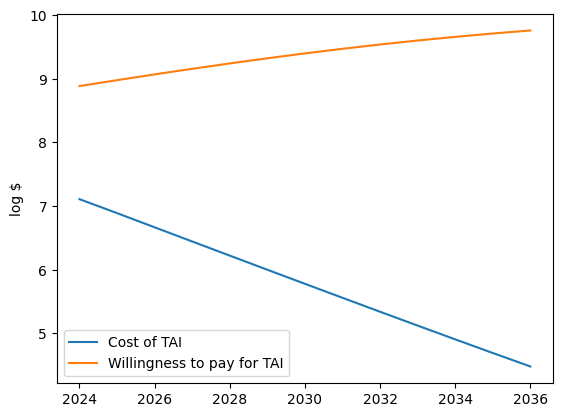

-
-
## SAMPLE RUN 15 ##
It takes 28.7 log FLOP (~50.1 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~13.6 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~34.1 sextillion) per 2023$USD.
We are initially willing to pay 8.8 log 2023$USD (~705.3 million). This doubles every 8.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2024 - 27.9 max log FLOP available - TAI takes 28.7 log FLOP - log 2023$USD 9.6 to buy TAI vs. willingness to pay log $ 8.8 - 19.1 log FLOP per $ (Total FLOP 27.9 vs. Effective 2023-logFLOP: 27.9)
Year: 2025 - 28.1 max log FLOP available - TAI takes 28.6 log FLOP - log 2023$USD 9.4 to buy TAI vs. willingness to pay log $ 8.8 - 19.2 log FLOP per $ (Total FLOP 28.1 vs. Effective 2023-logFLOP: 28.2)
Year: 2026 - 28.2 max log FLOP available - TAI take

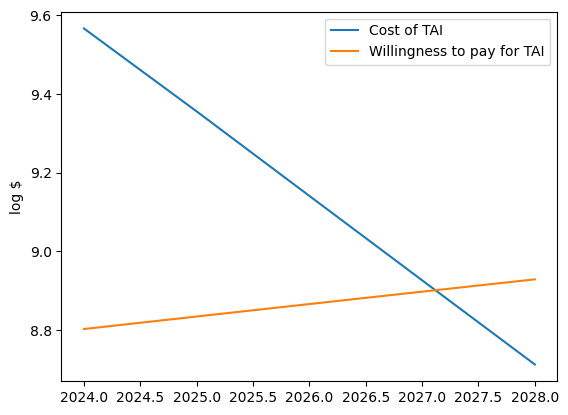

-
-
## SAMPLE RUN 16 ##
It takes 28.0 log FLOP (~10.0 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2.6 quintillion) per 2023$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~1.0 septillion) per 2023$USD.
We are initially willing to pay 8.9 log 2023$USD (~862.0 million). This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.2 billion 2023$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2024 - 27.3 max log FLOP available - TAI takes 28.0 log FLOP - log 2023$USD 9.6 to buy TAI vs. willingness to pay log $ 8.9 - 18.4 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
Year: 2025 - 27.6 max log FLOP available - TAI takes 27.9 log FLOP - log 2023$USD 9.3 to buy TAI vs. willingness to pay log $ 9.1 - 18.6 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.7)
Year: 2026 - 27.9 max log FLOP available - TAI takes 

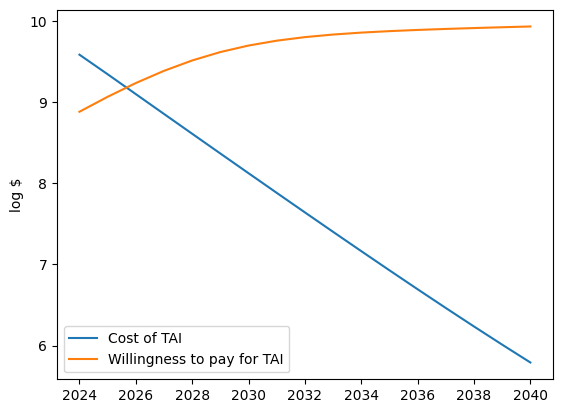

-
-
## SAMPLE RUN 17 ##
It takes 26.9 log FLOP (~794.3 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2023$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4.0 sextillion) per 2023$USD.
We are initially willing to pay 9.6 log 2023$USD (~3.6 billion). This doubles every 3.8 year to a max of 0.148974% of GDP (initially ~37.3 billion 2023$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2024 - 27.7 max log FLOP available - TAI takes 26.9 log FLOP - log 2023$USD 8.7 to buy TAI vs. willingness to pay log $ 9.5 - 18.2 log FLOP per $ (Total FLOP 27.7 vs. Effective 2023-logFLOP: 27.7)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- t

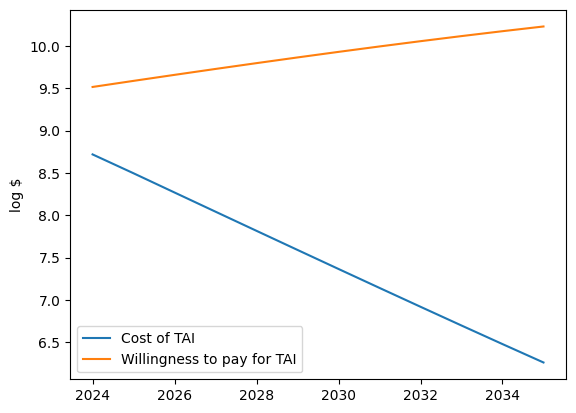

-
-
## SAMPLE RUN 18 ##
It takes 41.5 log FLOP (~316.2 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 2.1 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3.5 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 20.8 log FLOP (~635.8 quintillion) per 2023$USD.
We are initially willing to pay 8.9 log 2023$USD (~862.0 million). This doubles every 3.4 year to a max of 0.025% of GDP (initially ~6.2 billion 2023$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2024 - 27.4 max log FLOP available - TAI takes 41.5 log FLOP - log 2023$USD 23.0 to buy TAI vs. willingness to pay log $ 8.9 - 18.5 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.4)
Year: 2025 - 27.6 max log FLOP available - TAI takes 41.2 log FLOP - log 2023$USD 22.6 to buy TAI vs. willingness to pay log $ 9.0 - 18.7 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.9)
Year: 2026 - 27.8 max log FLOP availab

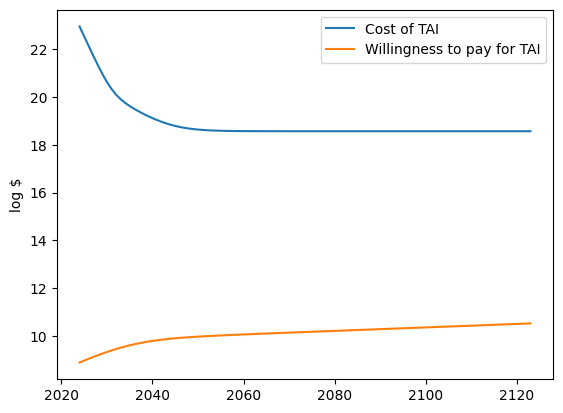

-
-
## SAMPLE RUN 19 ##
It takes 26.8 log FLOP (~631.0 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2023$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~523.3 sextillion) per 2023$USD.
We are initially willing to pay 8.6 log 2023$USD (~381.6 million). This doubles every 1.3 year to a max of 0.036871% of GDP (initially ~9.2 billion 2023$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2024 - 26.8 max log FLOP available - TAI takes 26.8 log FLOP - log 2023$USD 8.6 to buy TAI vs. willingness to pay log $ 8.6 - 18.2 log FLOP per $ (Total FLOP 26.8 vs. Effective 2023-logFLOP: 26.8)
Year: 2025 - 27.1 max log FLOP available - TAI takes 26.7 log FLOP - log 2023$USD 8.4 to buy TAI vs. willingness to pay log $ 8.8 - 18.3 log FLOP per $ (Total FLOP 27.1 vs. Effective 2023-logFLOP: 27.2)
-- algorithms p_nonscaling_issue p=0.3218 -> No

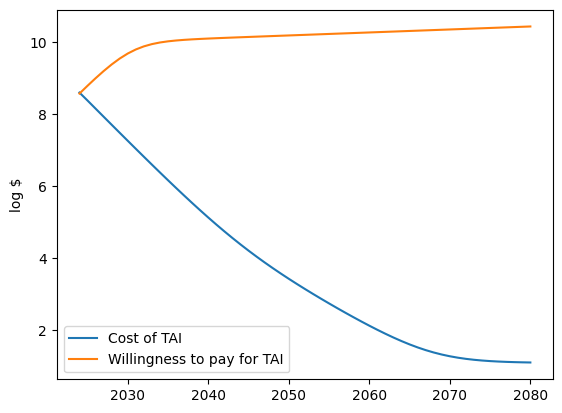

-
-
## SAMPLE RUN 20 ##
It takes 25.0 log FLOP (~10.0 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3.1 quintillion) per 2023$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.2 sextillion) per 2023$USD.
We are initially willing to pay 8.2 log 2023$USD (~154.6 million). This doubles every 7.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2024 - 26.7 max log FLOP available - TAI takes 25.0 log FLOP - log 2023$USD 6.5 to buy TAI vs. willingness to pay log $ 8.2 - 18.5 log FLOP per $ (Total FLOP 26.7 vs. Effective 2023-logFLOP: 26.7)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 4 years)
-- data p_nonscaling_issue p

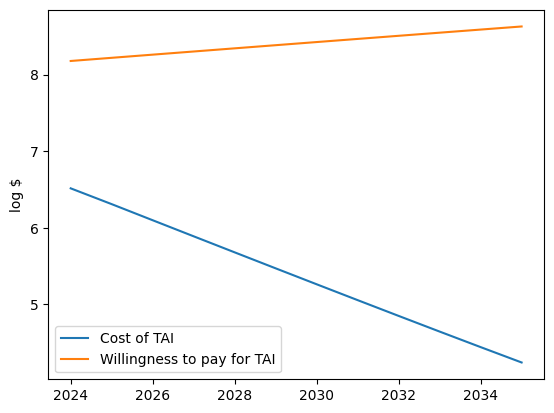

-
-
## SAMPLE RUN 21 ##
It takes 27.9 log FLOP (~7.9 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4.3 quintillion) per 2023$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4.3 sextillion) per 2023$USD.
We are initially willing to pay 9.1 log 2023$USD (~1.2 billion). This doubles every 8.8 year to a max of 0.145814% of GDP (initially ~36.5 billion 2023$USD). GDP grows at a rate of 1.005x per year.
---
Year: 2024 - 27.7 max log FLOP available - TAI takes 27.9 log FLOP - log 2023$USD 9.3 to buy TAI vs. willingness to pay log $ 9.1 - 18.6 log FLOP per $ (Total FLOP 27.7 vs. Effective 2023-logFLOP: 27.7)
Year: 2025 - 27.9 max log FLOP available - TAI takes 27.8 log FLOP - log 2023$USD 9.1 to buy TAI vs. willingness to pay log $ 9.1 - 18.8 log FLOP per $ (Total FLOP 27.9 vs. Effective 2023-logFLOP: 28.0)
-- algorithms p_nonscaling_issue p=0.3218 -> Nonscali

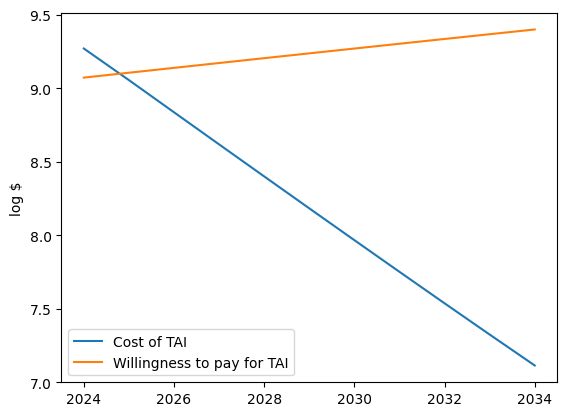

-
-
## SAMPLE RUN 22 ##
It takes 34.7 log FLOP (~50.1 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3.1 quintillion) per 2023$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12.2 sextillion) per 2023$USD.
We are initially willing to pay 9.0 log 2023$USD (~983.2 million). This doubles every 1.9 year to a max of 0.233209% of GDP (initially ~58.7 billion 2023$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2024 - 27.5 max log FLOP available - TAI takes 34.7 log FLOP - log 2023$USD 16.2 to buy TAI vs. willingness to pay log $ 9.0 - 18.5 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.5)
Year: 2025 - 27.8 max log FLOP available - TAI takes 34.5 log FLOP - log 2023$USD 15.9 to buy TAI vs. willingness to pay log $ 9.1 - 18.6 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 28.0)
Year: 2026 - 28.1 max log FLOP available - TA

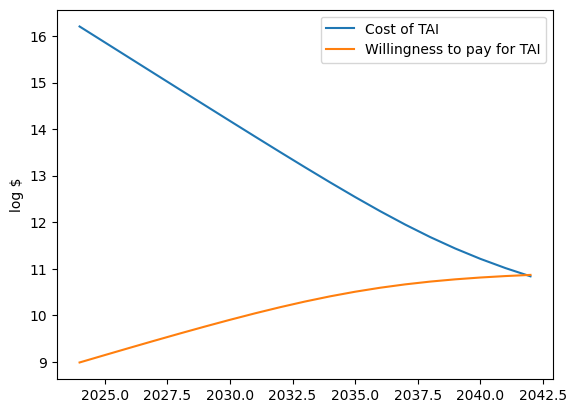

-
-
## SAMPLE RUN 23 ##
It takes 29.6 log FLOP (~398.1 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~1.8 quintillion) per 2023$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~109.9 sextillion) per 2023$USD.
We are initially willing to pay 9.0 log 2023$USD (~983.1 million). This doubles every 0.9 year to a max of 0.231979% of GDP (initially ~58.2 billion 2023$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2024 - 27.2 max log FLOP available - TAI takes 29.6 log FLOP - log 2023$USD 11.3 to buy TAI vs. willingness to pay log $ 9.0 - 18.3 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.2)
Year: 2025 - 27.7 max log FLOP available - TAI takes 29.5 log FLOP - log 2023$USD 11.1 to buy TAI vs. willingness to pay log $ 9.3 - 18.4 log FLOP per $ (Total FLOP 27.7 vs. Effective 2023-logFLOP: 27.8)
Year: 2026 - 28.1 max log FLOP available - T

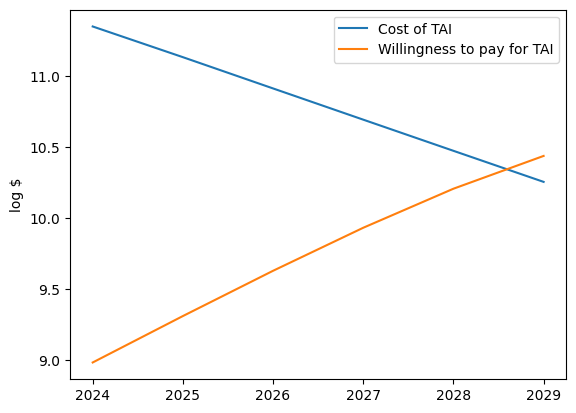

-
-
## SAMPLE RUN 24 ##
It takes 25.8 log FLOP (~63.1 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~11.0 quintillion) per 2023$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~26.2 sextillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~1.8 billion). This doubles every 4.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2024 - 28.2 max log FLOP available - TAI takes 25.8 log FLOP - log 2023$USD 6.8 to buy TAI vs. willingness to pay log $ 9.1 - 19.0 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.2)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this

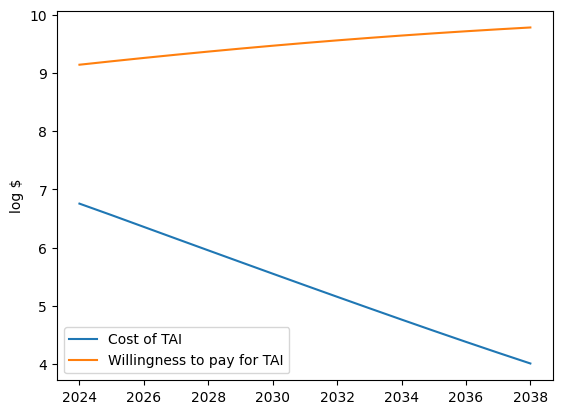

-
-
## SAMPLE RUN 25 ##
It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~7.1 quintillion) per 2023$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~888.6 sextillion) per 2023$USD.
We are initially willing to pay 8.9 log 2023$USD (~755.6 million). This doubles every 8.0 year to a max of 0.061661% of GDP (initially ~15.5 billion 2023$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2024 - 27.7 max log FLOP available - TAI takes 26.5 log FLOP - log 2023$USD 7.6 to buy TAI vs. willingness to pay log $ 8.9 - 18.9 log FLOP per $ (Total FLOP 27.7 vs. Effective 2023-logFLOP: 27.7)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occ

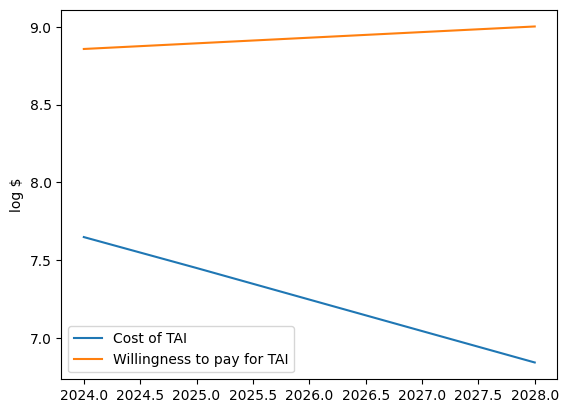

-
-
## SAMPLE RUN 26 ##
It takes 27.7 log FLOP (~5.0 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8.3 quintillion) per 2023$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~2.3 sextillion) per 2023$USD.
We are initially willing to pay 8.7 log 2023$USD (~496.6 million). This doubles every 6.2 year to a max of 0.217241% of GDP (initially ~54.4 billion 2023$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2024 - 27.6 max log FLOP available - TAI takes 27.7 log FLOP - log 2023$USD 8.8 to buy TAI vs. willingness to pay log $ 8.7 - 18.9 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.6)
Year: 2025 - 27.8 max log FLOP available - TAI takes 27.6 log FLOP - log 2023$USD 8.6 to buy TAI vs. willingness to pay log $ 8.7 - 19.0 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.9)
-- algorithms p_nonscaling_issue p=0.3218 -> Nonsca

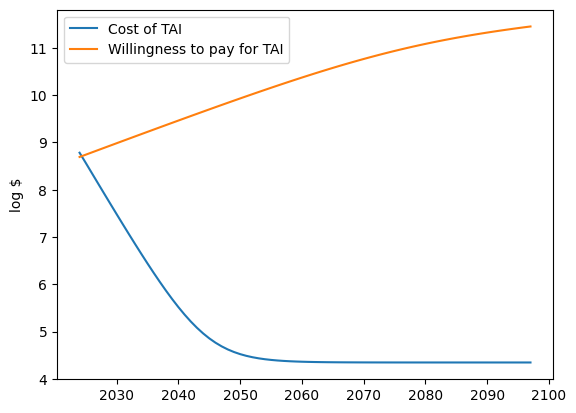

-
-
## SAMPLE RUN 27 ##
It takes 27.9 log FLOP (~7.9 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~5.9 quintillion) per 2023$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~443.3 sextillion) per 2023$USD.
We are initially willing to pay 9.1 log 2023$USD (~1.3 billion). This doubles every 9.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2024 - 27.8 max log FLOP available - TAI takes 27.9 log FLOP - log 2023$USD 9.1 to buy TAI vs. willingness to pay log $ 9.0 - 18.8 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.8)
Year: 2025 - 27.9 max log FLOP available - TAI takes 27.8 log FLOP - log 2023$USD 8.9 to buy TAI vs. willingness to pay log $ 9.0 - 18.9 log FLOP per $ (Total FLOP 27.9 vs. Effective 2023-logFLOP: 28.0)
-- algorithms p_nonscaling_issue p=0.3218 -> Nonscaling

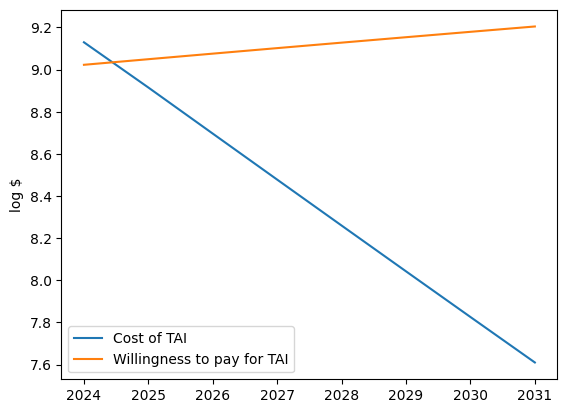

-
-
## SAMPLE RUN 28 ##
It takes 32.6 log FLOP (~398.1 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2.6 quintillion) per 2023$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~6.0 septillion) per 2023$USD.
We are initially willing to pay 9.5 log 2023$USD (~3.5 billion). This doubles every 3.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.028x per year.
---
Year: 2024 - 27.8 max log FLOP available - TAI takes 32.6 log FLOP - log 2023$USD 14.2 to buy TAI vs. willingness to pay log $ 9.4 - 18.4 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.8)
Year: 2025 - 28.0 max log FLOP available - TAI takes 32.5 log FLOP - log 2023$USD 13.9 to buy TAI vs. willingness to pay log $ 9.4 - 18.5 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.1)
Year: 2026 - 28.1 max log FLOP available - TAI take

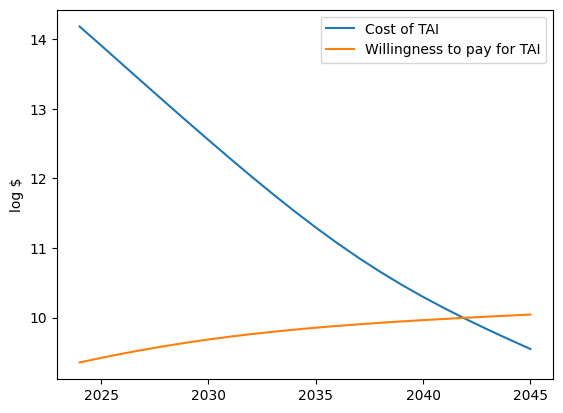

-
-
## SAMPLE RUN 29 ##
It takes 46.9 log FLOP (~79.4 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4.1 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~9.0 quintillion) per 2023$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~117.2 sextillion) per 2023$USD.
We are initially willing to pay 8.8 log 2023$USD (~573.5 million). This doubles every 2.6 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2024 - 27.7 max log FLOP available - TAI takes 46.9 log FLOP - log 2023$USD 27.9 to buy TAI vs. willingness to pay log $ 8.7 - 19.0 log FLOP per $ (Total FLOP 27.7 vs. Effective 2023-logFLOP: 27.7)
Year: 2025 - 27.9 max log FLOP available - TAI takes 46.6 log FLOP - log 2023$USD 27.5 to buy TAI vs. willingness to pay log $ 8.8 - 19.1 log FLOP per $ (Total FLOP 27.9 vs. Effective 2023-logFLOP: 28.2)
Year: 2026 - 28.1 max log FLOP availabl

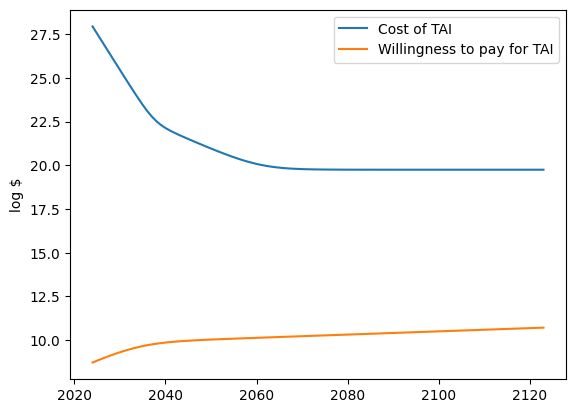

-
-
## SAMPLE RUN 30 ##
It takes 26.9 log FLOP (~794.3 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5.6 quintillion) per 2023$USD. Every 3.0 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~281.4 sextillion) per 2023$USD.
We are initially willing to pay 9.0 log 2023$USD (~1.0 billion). This doubles every 11.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.012x per year.
---
Year: 2024 - 27.7 max log FLOP available - TAI takes 26.9 log FLOP - log 2023$USD 8.2 to buy TAI vs. willingness to pay log $ 9.0 - 18.7 log FLOP per $ (Total FLOP 27.7 vs. Effective 2023-logFLOP: 27.7)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
--

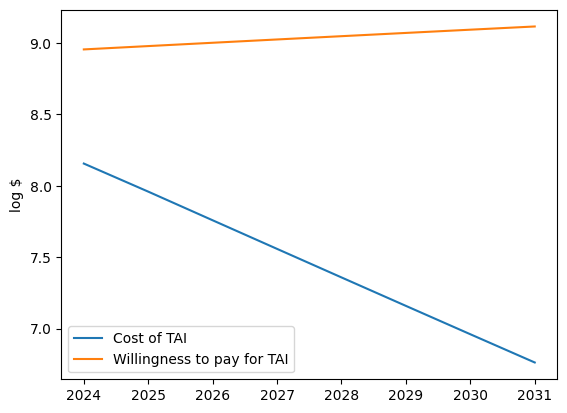

-
-
## SAMPLE RUN 31 ##
It takes 30.9 log FLOP (~7.9 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2.7 quintillion) per 2023$USD. Every 3.1 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~795.3 quintillion) per 2023$USD.
We are initially willing to pay 9.6 log 2023$USD (~3.6 billion). This doubles every 3.0 year to a max of 0.139782% of GDP (initially ~35.0 billion 2023$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2024 - 27.9 max log FLOP available - TAI takes 30.9 log FLOP - log 2023$USD 12.5 to buy TAI vs. willingness to pay log $ 9.5 - 18.4 log FLOP per $ (Total FLOP 27.9 vs. Effective 2023-logFLOP: 27.9)
Year: 2025 - 28.1 max log FLOP available - TAI takes 30.8 log FLOP - log 2023$USD 12.3 to buy TAI vs. willingness to pay log $ 9.6 - 18.5 log FLOP per $ (Total FLOP 28.1 vs. Effective 2023-logFLOP: 28.3)
Year: 2026 - 28.3 max log FLOP available - TAI

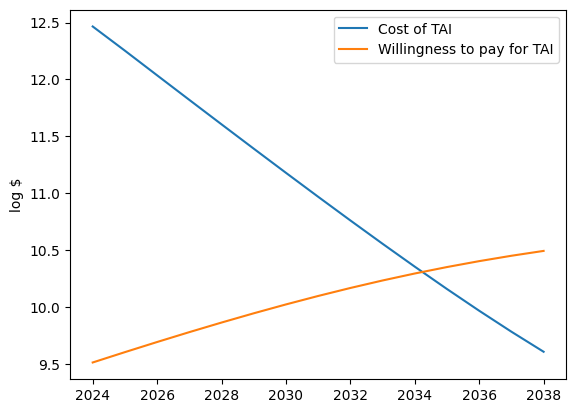

-
-
## SAMPLE RUN 32 ##
It takes 26.9 log FLOP (~794.3 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~11.7 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.7 septillion) per 2023$USD.
We are initially willing to pay 9.6 log 2023$USD (~3.8 billion). This doubles every 2.2 year to a max of 0.065972% of GDP (initially ~16.4 billion 2023$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2024 - 28.6 max log FLOP available - TAI takes 26.9 log FLOP - log 2023$USD 7.8 to buy TAI vs. willingness to pay log $ 9.5 - 19.1 log FLOP per $ (Total FLOP 28.6 vs. Effective 2023-logFLOP: 28.6)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- 

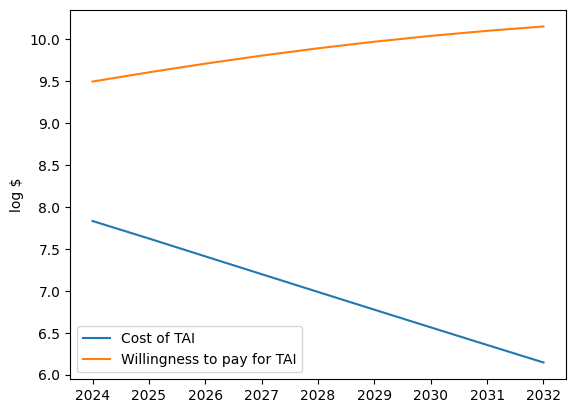

-
-
## SAMPLE RUN 33 ##
It takes 30.5 log FLOP (~3.2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~4.9 quintillion) per 2023$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~46.2 sextillion) per 2023$USD.
We are initially willing to pay 8.7 log 2023$USD (~464.3 million). This doubles every 4.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2024 - 27.3 max log FLOP available - TAI takes 30.5 log FLOP - log 2023$USD 11.8 to buy TAI vs. willingness to pay log $ 8.6 - 18.7 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
Year: 2025 - 27.5 max log FLOP available - TAI takes 30.4 log FLOP - log 2023$USD 11.6 to buy TAI vs. willingness to pay log $ 8.7 - 18.8 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.6)
Year: 2026 - 27.7 max log FLOP available - TAI take

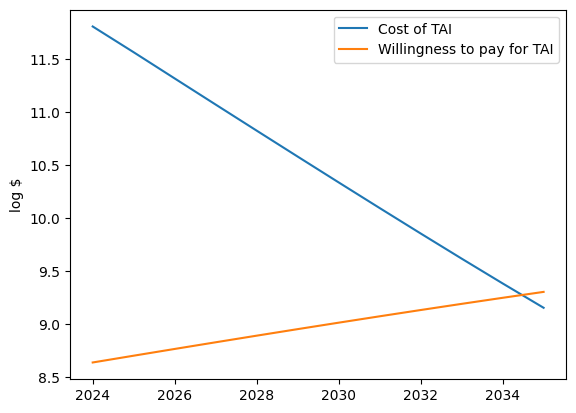

-
-
## SAMPLE RUN 34 ##
It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5.4 quintillion) per 2023$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.5 septillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~2.1 billion). This doubles every 4.5 year to a max of 0.025% of GDP (initially ~6.2 billion 2023$USD). GDP grows at a rate of 1.036x per year.
---
Year: 2024 - 27.9 max log FLOP available - TAI takes 26.5 log FLOP - log 2023$USD 7.8 to buy TAI vs. willingness to pay log $ 9.2 - 18.7 log FLOP per $ (Total FLOP 27.9 vs. Effective 2023-logFLOP: 27.9)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this 

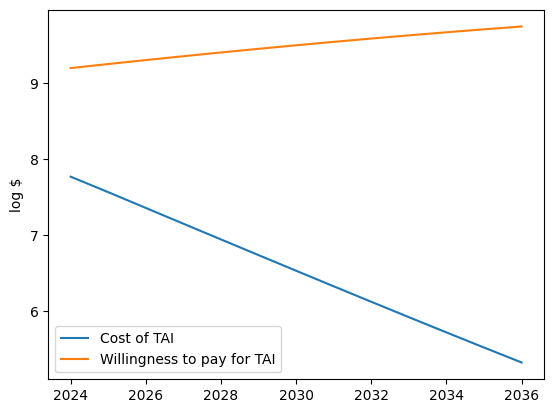

-
-
## SAMPLE RUN 35 ##
It takes 31.3 log FLOP (~20.0 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2023$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~179.5 sextillion) per 2023$USD.
We are initially willing to pay 8.8 log 2023$USD (~572.7 million). This doubles every 3.4 year to a max of 0.025% of GDP (initially ~6.2 billion 2023$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2024 - 27.0 max log FLOP available - TAI takes 31.3 log FLOP - log 2023$USD 13.0 to buy TAI vs. willingness to pay log $ 8.7 - 18.3 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.0)
Year: 2025 - 27.2 max log FLOP available - TAI takes 31.2 log FLOP - log 2023$USD 12.8 to buy TAI vs. willingness to pay log $ 8.8 - 18.4 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.3)
Year: 2026 - 27.4 max log FLOP available - TAI t

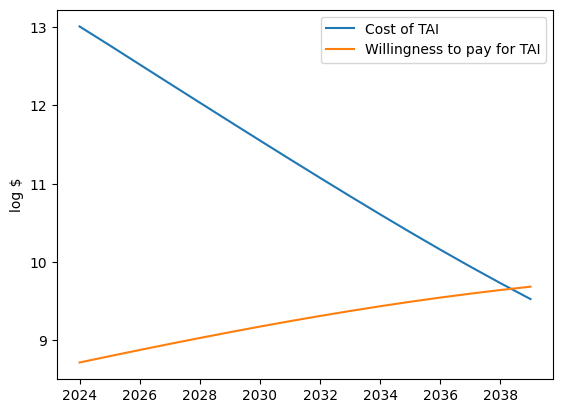

-
-
## SAMPLE RUN 36 ##
It takes 39.7 log FLOP (~5.0 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2023$USD. Every 2.8 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7.5 sextillion) per 2023$USD.
We are initially willing to pay 9.0 log 2023$USD (~1.1 billion). This doubles every 5.4 year to a max of 0.029036% of GDP (initially ~7.3 billion 2023$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2024 - 27.5 max log FLOP available - TAI takes 39.7 log FLOP - log 2023$USD 21.2 to buy TAI vs. willingness to pay log $ 9.0 - 18.5 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.5)
Year: 2025 - 27.6 max log FLOP available - TAI takes 39.4 log FLOP - log 2023$USD 20.8 to buy TAI vs. willingness to pay log $ 9.0 - 18.6 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.9)
Year: 2026 - 27.8 max log FLOP available - TA

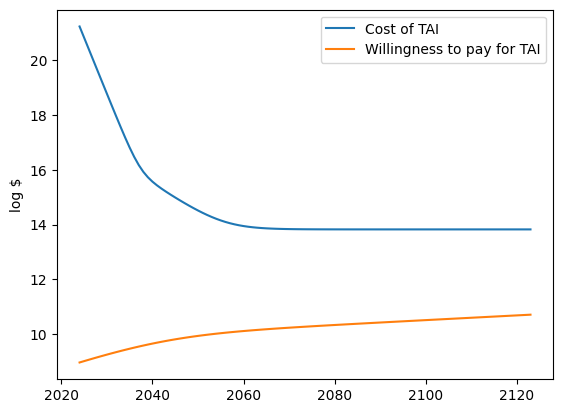

-
-
## SAMPLE RUN 37 ##
It takes 28.8 log FLOP (~63.1 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~17.2 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~13.5 septillion) per 2023$USD.
We are initially willing to pay 9.7 log 2023$USD (~5.6 billion). This doubles every 1.9 year to a max of 0.186985% of GDP (initially ~46.7 billion 2023$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2024 - 28.9 max log FLOP available - TAI takes 28.8 log FLOP - log 2023$USD 9.6 to buy TAI vs. willingness to pay log $ 9.7 - 19.2 log FLOP per $ (Total FLOP 28.9 vs. Effective 2023-logFLOP: 28.9)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur


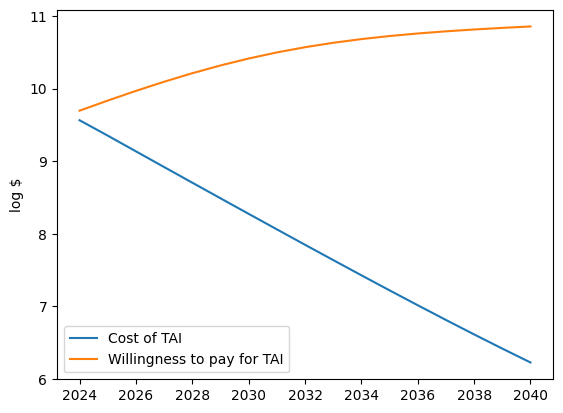

-
-
## SAMPLE RUN 38 ##
It takes 31.3 log FLOP (~20.0 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~9.9 quintillion) per 2023$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~310.7 sextillion) per 2023$USD.
We are initially willing to pay 8.0 log 2023$USD (~98.4 million). This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.2 billion 2023$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2024 - 27.0 max log FLOP available - TAI takes 31.3 log FLOP - log 2023$USD 12.3 to buy TAI vs. willingness to pay log $ 8.0 - 19.0 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.0)
Year: 2025 - 27.3 max log FLOP available - TAI takes 31.2 log FLOP - log 2023$USD 12.1 to buy TAI vs. willingness to pay log $ 8.2 - 19.1 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.4)
Year: 2026 - 27.7 max log FLOP available - TAI ta

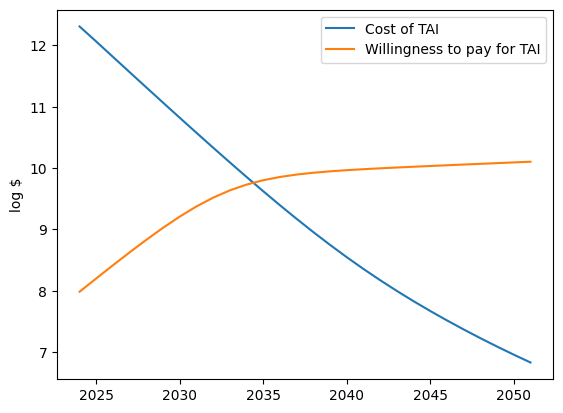

-
-
## SAMPLE RUN 39 ##
It takes 33.0 log FLOP (~1000.0 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2023$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~1.8 septillion) per 2023$USD.
We are initially willing to pay 9.7 log 2023$USD (~5.0 billion). This doubles every 1.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2024 - 27.6 max log FLOP available - TAI takes 33.0 log FLOP - log 2023$USD 14.9 to buy TAI vs. willingness to pay log $ 9.4 - 18.1 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.6)
Year: 2025 - 27.8 max log FLOP available - TAI takes 32.9 log FLOP - log 2023$USD 14.6 to buy TAI vs. willingness to pay log $ 9.5 - 18.2 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.9)
Year: 2026 - 28.0 max log FLOP available - TAI tak

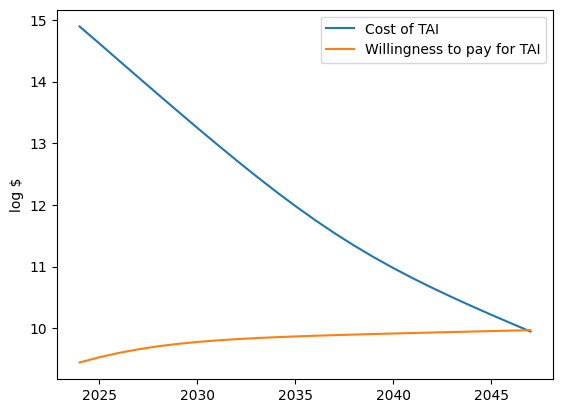

-
-
## SAMPLE RUN 40 ##
It takes 30.1 log FLOP (~1.3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~13.2 quintillion) per 2023$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~952.8 sextillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~1.9 billion). This doubles every 2.8 year to a max of 0.154077% of GDP (initially ~38.8 billion 2023$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2024 - 28.4 max log FLOP available - TAI takes 30.1 log FLOP - log 2023$USD 11.0 to buy TAI vs. willingness to pay log $ 9.3 - 19.1 log FLOP per $ (Total FLOP 28.4 vs. Effective 2023-logFLOP: 28.4)
Year: 2025 - 28.6 max log FLOP available - TAI takes 30.0 log FLOP - log 2023$USD 10.8 to buy TAI vs. willingness to pay log $ 9.4 - 19.2 log FLOP per $ (Total FLOP 28.6 vs. Effective 2023-logFLOP: 28.7)
Year: 2026 - 28.8 max log FLOP available - TAI

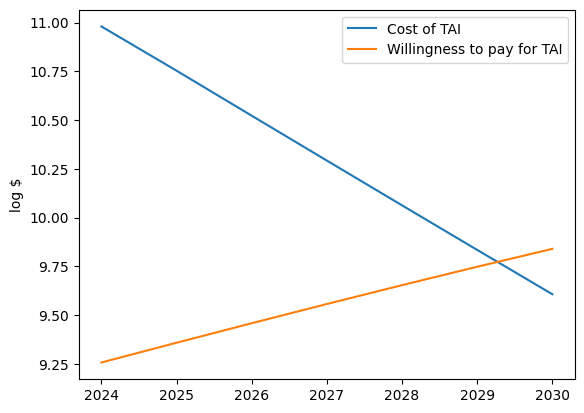

-
-
## SAMPLE RUN 41 ##
It takes 42.4 log FLOP (~2.5 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2.5 quintillion) per 2023$USD. Every 3.0 years they get 2x cheaper, to a maximum of 25.8 log FLOP (~68.0 septillion) per 2023$USD.
We are initially willing to pay 8.4 log 2023$USD (~246.4 million). This doubles every 1.1 year to a max of 0.05194% of GDP (initially ~13.0 billion 2023$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2024 - 26.8 max log FLOP available - TAI takes 42.4 log FLOP - log 2023$USD 24.0 to buy TAI vs. willingness to pay log $ 8.4 - 18.4 log FLOP per $ (Total FLOP 26.8 vs. Effective 2023-logFLOP: 26.8)
Year: 2025 - 27.1 max log FLOP available - TAI takes 42.1 log FLOP - log 2023$USD 23.6 to buy TAI vs. willingness to pay log $ 8.6 - 18.5 log FLOP per $ (Total FLOP 27.1 vs. Effective 2023-logFLOP: 27.4)
Year: 2026 - 27.5 max log FLOP available 

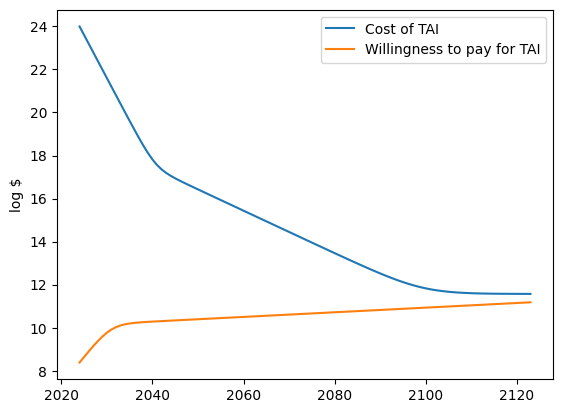

-
-
## SAMPLE RUN 42 ##
It takes 26.2 log FLOP (~158.5 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4.2 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~2.9 sextillion) per 2023$USD.
We are initially willing to pay 8.9 log 2023$USD (~862.6 million). This doubles every 3.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.035x per year.
---
Year: 2024 - 27.5 max log FLOP available - TAI takes 26.2 log FLOP - log 2023$USD 7.6 to buy TAI vs. willingness to pay log $ 8.9 - 18.6 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.5)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 10 years)
-- data p_nonscaling_issu

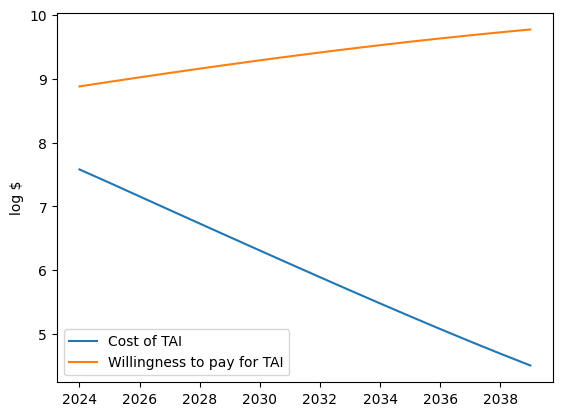

-
-
## SAMPLE RUN 43 ##
It takes 32.8 log FLOP (~631.0 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5.1 quintillion) per 2023$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5.4 sextillion) per 2023$USD.
We are initially willing to pay 9.2 log 2023$USD (~1.6 billion). This doubles every 3.3 year to a max of 0.032043% of GDP (initially ~8.0 billion 2023$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2024 - 27.8 max log FLOP available - TAI takes 32.8 log FLOP - log 2023$USD 14.1 to buy TAI vs. willingness to pay log $ 9.1 - 18.7 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.8)
Year: 2025 - 28.0 max log FLOP available - TAI takes 32.7 log FLOP - log 2023$USD 13.8 to buy TAI vs. willingness to pay log $ 9.2 - 18.8 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.2)
Year: 2026 - 28.3 max log FLOP available - TAI t

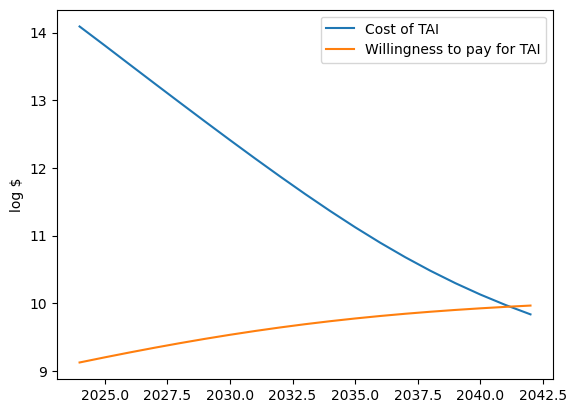

-
-
## SAMPLE RUN 44 ##
It takes 26.0 log FLOP (~100.0 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~507.5 sextillion) per 2023$USD.
We are initially willing to pay 8.2 log 2023$USD (~158.2 million). This doubles every 2.1 year to a max of 0.299502% of GDP (initially ~75.6 billion 2023$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2024 - 26.4 max log FLOP available - TAI takes 26.0 log FLOP - log 2023$USD 7.8 to buy TAI vs. willingness to pay log $ 8.2 - 18.2 log FLOP per $ (Total FLOP 26.4 vs. Effective 2023-logFLOP: 26.4)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occu

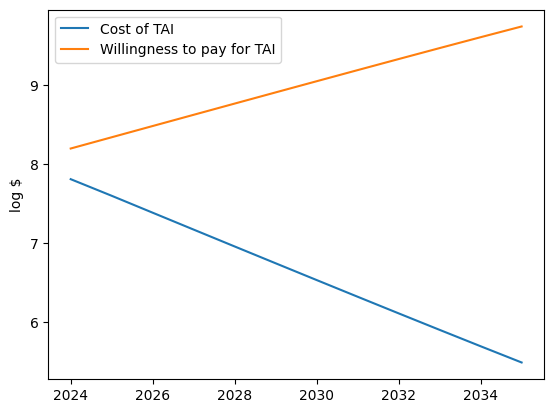

-
-
## SAMPLE RUN 45 ##
It takes 30.2 log FLOP (~1.6 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5.4 quintillion) per 2023$USD. Every 2.1 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~44.1 sextillion) per 2023$USD.
We are initially willing to pay 8.8 log 2023$USD (~573.7 million). This doubles every 5.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2024 - 27.4 max log FLOP available - TAI takes 30.2 log FLOP - log 2023$USD 11.5 to buy TAI vs. willingness to pay log $ 8.7 - 18.7 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.4)
Year: 2025 - 27.6 max log FLOP available - TAI takes 30.1 log FLOP - log 2023$USD 11.2 to buy TAI vs. willingness to pay log $ 8.8 - 18.9 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.8)
Year: 2026 - 27.8 max log FLOP available - TAI tak

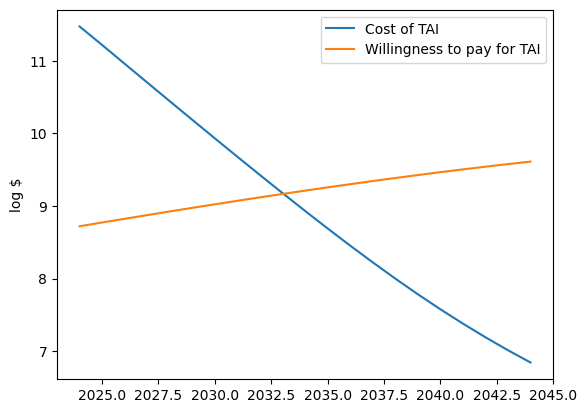

-
-
## SAMPLE RUN 46 ##
It takes 28.4 log FLOP (~25.1 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.7 log FLOP (~49.2 quintillion) per 2023$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~620.3 sextillion) per 2023$USD.
We are initially willing to pay 8.7 log 2023$USD (~463.9 million). This doubles every 1.8 year to a max of 0.025% of GDP (initially ~6.2 billion 2023$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2024 - 28.3 max log FLOP available - TAI takes 28.4 log FLOP - log 2023$USD 8.7 to buy TAI vs. willingness to pay log $ 8.6 - 19.7 log FLOP per $ (Total FLOP 28.3 vs. Effective 2023-logFLOP: 28.3)
Year: 2025 - 28.6 max log FLOP available - TAI takes 28.3 log FLOP - log 2023$USD 8.5 to buy TAI vs. willingness to pay log $ 8.8 - 19.8 log FLOP per $ (Total FLOP 28.6 vs. Effective 2023-logFLOP: 28.7)
-- algorithms p_nonscaling_issue p=0.3218 -> Nons

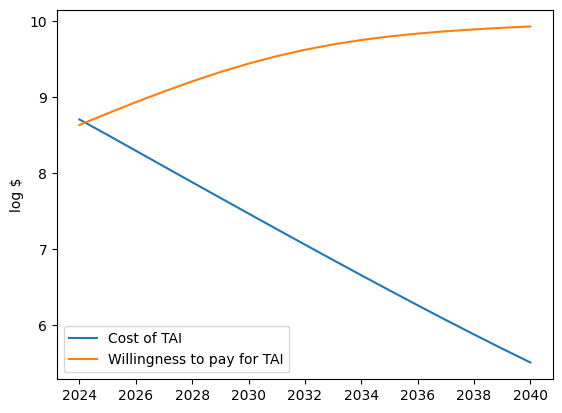

-
-
## SAMPLE RUN 47 ##
It takes 26.1 log FLOP (~125.9 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5.4 quintillion) per 2023$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~965.5 sextillion) per 2023$USD.
We are initially willing to pay 9.7 log 2023$USD (~5.0 billion). This doubles every 2.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2024 - 28.2 max log FLOP available - TAI takes 26.1 log FLOP - log 2023$USD 7.4 to buy TAI vs. willingness to pay log $ 9.4 - 18.7 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.2)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- thi

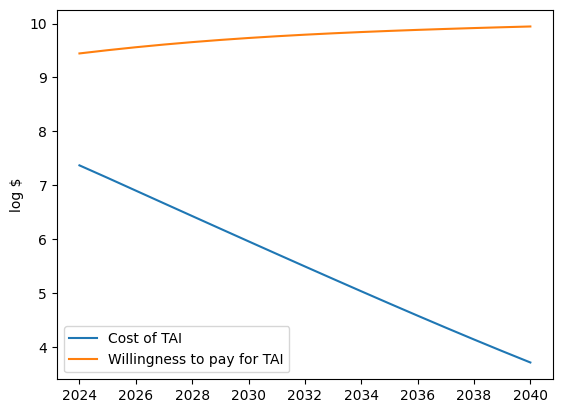

-
-
## SAMPLE RUN 48 ##
It takes 28.5 log FLOP (~31.6 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~4.9 quintillion) per 2023$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~131.1 sextillion) per 2023$USD.
We are initially willing to pay 9.1 log 2023$USD (~1.2 billion). This doubles every 4.2 year to a max of 0.287918% of GDP (initially ~72.2 billion 2023$USD). GDP grows at a rate of 1.028x per year.
---
Year: 2024 - 27.8 max log FLOP available - TAI takes 28.5 log FLOP - log 2023$USD 9.8 to buy TAI vs. willingness to pay log $ 9.1 - 18.7 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.8)
Year: 2025 - 28.0 max log FLOP available - TAI takes 28.4 log FLOP - log 2023$USD 9.6 to buy TAI vs. willingness to pay log $ 9.2 - 18.8 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.1)
Year: 2026 - 28.2 max log FLOP available - TAI t

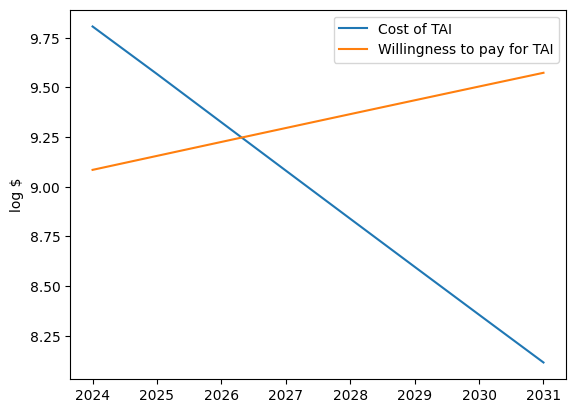

-
-
## SAMPLE RUN 49 ##
It takes 30.6 log FLOP (~4.0 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2023$USD. Every 2.0 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.5 septillion) per 2023$USD.
We are initially willing to pay 9.2 log 2023$USD (~1.7 billion). This doubles every 1.9 year to a max of 0.05066% of GDP (initially ~12.8 billion 2023$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2024 - 27.6 max log FLOP available - TAI takes 30.6 log FLOP - log 2023$USD 12.2 to buy TAI vs. willingness to pay log $ 9.2 - 18.4 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.6)
Year: 2025 - 27.8 max log FLOP available - TAI takes 30.5 log FLOP - log 2023$USD 12.0 to buy TAI vs. willingness to pay log $ 9.3 - 18.5 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 28.0)
Year: 2026 - 28.1 max log FLOP available - TAI tak

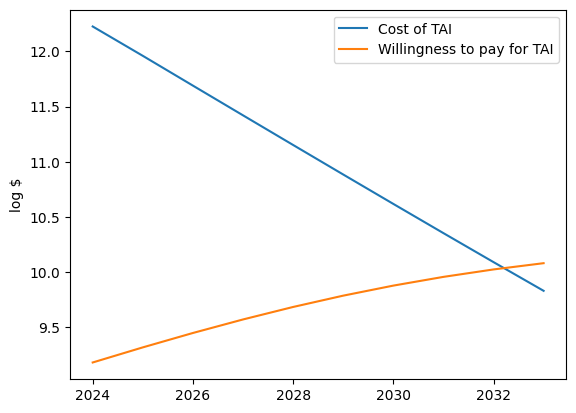

-
-
## SAMPLE RUN 50 ##
It takes 32.8 log FLOP (~631.0 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4.2 quintillion) per 2023$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~1.1 septillion) per 2023$USD.
We are initially willing to pay 8.8 log 2023$USD (~573.4 million). This doubles every 1.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2024 - 27.3 max log FLOP available - TAI takes 32.8 log FLOP - log 2023$USD 14.2 to buy TAI vs. willingness to pay log $ 8.7 - 18.6 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
Year: 2025 - 27.7 max log FLOP available - TAI takes 32.7 log FLOP - log 2023$USD 13.9 to buy TAI vs. willingness to pay log $ 8.9 - 18.8 log FLOP per $ (Total FLOP 27.7 vs. Effective 2023-logFLOP: 27.8)
Year: 2026 - 28.0 max log FLOP available - TAI ta

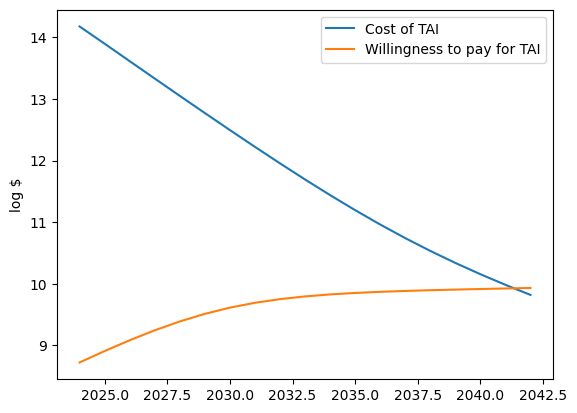

-
-
## SAMPLE RUN 51 ##
It takes 40.7 log FLOP (~50.1 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2.6 quintillion) per 2023$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~2.9 septillion) per 2023$USD.
We are initially willing to pay 9.6 log 2023$USD (~3.9 billion). This doubles every 2.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2023$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2024 - 27.8 max log FLOP available - TAI takes 40.7 log FLOP - log 2023$USD 22.3 to buy TAI vs. willingness to pay log $ 9.4 - 18.4 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.8)
Year: 2025 - 28.0 max log FLOP available - TAI takes 40.4 log FLOP - log 2023$USD 21.9 to buy TAI vs. willingness to pay log $ 9.4 - 18.5 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.3)
Year: 2026 - 28.2 max log FLOP available - TAI

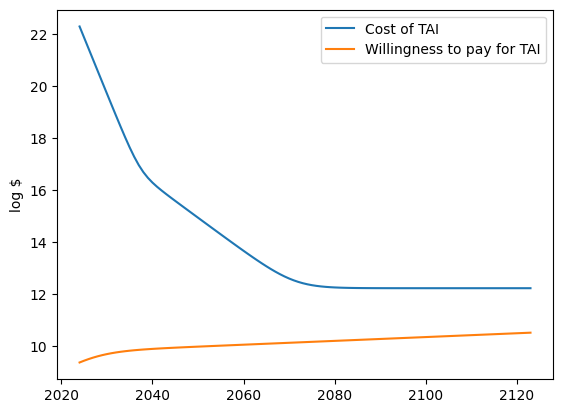

-
-
## SAMPLE RUN 52 ##
It takes 47.5 log FLOP (~316.2 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.4 log reductions possible.
FLOP start at a cost of 19.5 log FLOP (~31.9 quintillion) per 2023$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~54.9 sextillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~2.0 billion). This doubles every 6.0 year to a max of 0.039832% of GDP (initially ~10.0 billion 2023$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2024 - 28.7 max log FLOP available - TAI takes 47.5 log FLOP - log 2023$USD 28.0 to buy TAI vs. willingness to pay log $ 9.2 - 19.5 log FLOP per $ (Total FLOP 28.7 vs. Effective 2023-logFLOP: 28.7)
Year: 2025 - 28.9 max log FLOP available - TAI takes 47.2 log FLOP - log 2023$USD 27.6 to buy TAI vs. willingness to pay log $ 9.3 - 19.6 log FLOP per $ (Total FLOP 28.9 vs. Effective 2023-logFLOP: 29.2)
Year: 2026 - 29.1 max log FLOP avail

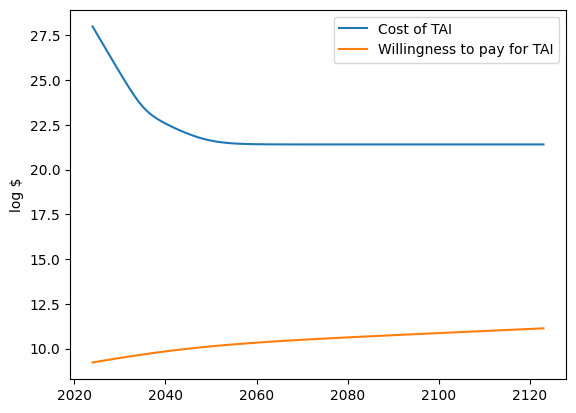

-
-
## SAMPLE RUN 53 ##
It takes 42.6 log FLOP (~4.0 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~16.3 quintillion) per 2023$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~70.1 sextillion) per 2023$USD.
We are initially willing to pay 9.2 log 2023$USD (~1.5 billion). This doubles every 3.7 year to a max of 0.172355% of GDP (initially ~43.4 billion 2023$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2024 - 28.4 max log FLOP available - TAI takes 42.6 log FLOP - log 2023$USD 23.4 to buy TAI vs. willingness to pay log $ 9.2 - 19.2 log FLOP per $ (Total FLOP 28.4 vs. Effective 2023-logFLOP: 28.4)
Year: 2025 - 28.6 max log FLOP available - TAI takes 42.3 log FLOP - log 2023$USD 23.0 to buy TAI vs. willingness to pay log $ 9.2 - 19.3 log FLOP per $ (Total FLOP 28.6 vs. Effective 2023-logFLOP: 28.9)
Year: 2026 - 28.7 max log FLOP available 

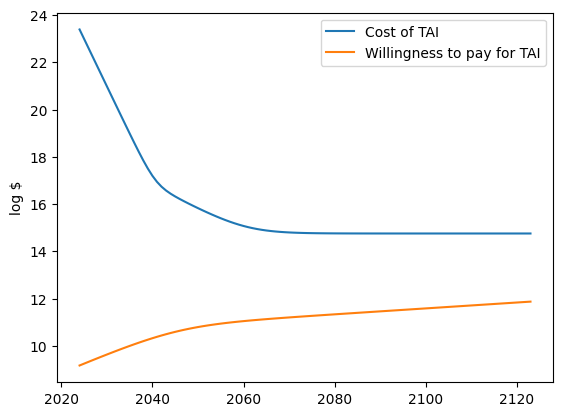

In [14]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [15]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-03-15 12:32:16.270387
